In [1]:
# notebook ran in pandas21 environment
import os
import re
import glob
import pandas as pd
import scipy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from Bio.Blast import NCBIWWW
from Bio import SeqIO
from Bio import SearchIO
import seaborn as sns
from matplotlib import gridspec
from itertools import combinations
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import time
import os.path
from os import path

# function to create colour dictionaries from a colour map and a list of items
def colourDict(data,cmap=mpl.cm.viridis,sort=False):
    """
    returns a dictionary of unique data_items:colour hex code, normalised
    takes a list of items and a cmap as mpl.cm.name. If sort = False, the function takes an ordered list of unique elements
    """
    cmap=cmap # default viridis
    data_unique=data if sort == False else list(set(data)) # includes nan values as a key. That is desirable sometimes
    norm = mpl.colors.Normalize(vmin=0, vmax=len(data_unique))
    colors = [cmap(norm(value)) for value in range(len(data_unique))]
    return dict(zip(data_unique,colors))

# Pairwise Fst calculations from poolfstats

In [2]:
glbfst = pd.read_csv('./GM_SNPs_Fst_2023/pairwisefst_minmaf5_2023.txt', sep = '\t') #, index_col = 'pairwisefst')
# NaN in diagonal have been replaced by zeros
labeldict = {'P13454_101':'Gm\nmacrostachys A',
             'P13454_102':'Gm\nmacrostachys S',
             'P13454_103':'Gm\nacaulis S',
             'P13454_104':'Gm\nacaulis A'}
glbfst['samples'] = glbfst['pairwisefst'].map(labeldict)
glbfstlab = glbfst.rename(columns = labeldict)
glbfstlab.set_index('samples', inplace = True)
glbfstlab.drop(columns = 'pairwisefst', inplace = True)
glbfstlab

,Gm\nmacrostachys A,Gm\nmacrostachys S,Gm\nacaulis S,Gm\nacaulis A
samples,,,,
Gm\nmacrostachys A,0.000000,-0.004520,0.106826,0.142671
Gm\nmacrostachys S,-0.004520,0.000000,0.118267,0.155736
Gm\nacaulis S,0.106826,0.118267,0.000000,0.001806
Gm\nacaulis A,0.142671,0.155736,0.001806,0.000000


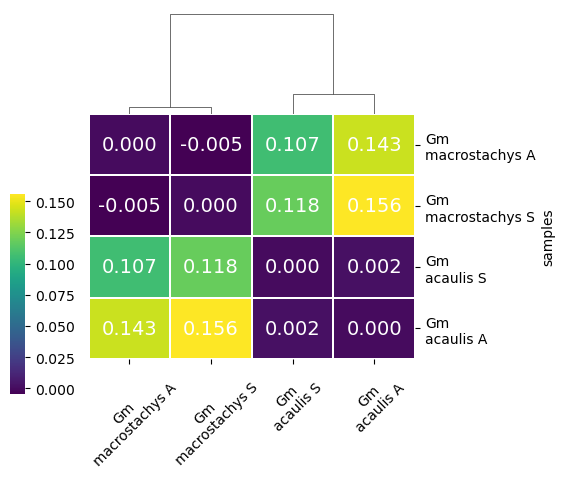

In [3]:
# fig,ax=plt.subplots(figsize=(5,5),facecolor='w')

labelcolor='#4f4f4f'

# 'fontweight':'bold' #e3e3e3
hm = sns.clustermap(glbfstlab, figsize = (5,5), row_cluster = False, dendrogram_ratio = (.01, .3),
     cbar_pos = (-0.12, .2, .03, .4), cmap = 'viridis', linewidths = .75,
     annot = True, fmt = '.3f', annot_kws = {'fontsize':14,'color':'w'})

plt.setp(hm.ax_heatmap.xaxis.get_majorticklabels(), rotation=45)

# plt.savefig('../figures//Cor_allvariables_20220812.pdf',dpi=300,bbox_inches='tight')
plt.show()

# Process files and create dataframe

In [4]:
# upload files
path=os.getcwd()
ext='./GM_SNPs_Fst_2023/*glb_sliding10m.txt'

data=pd.DataFrame(columns=['chr','position','cumulatedposition','multilocusfst','pair'])

for filename in glob.glob(os.path.join(path,'%s'%(ext))):
    pair=filename.split('/')[-1].split('glb')[0]
    tempdata=pd.read_csv(filename,names=['chr','position','cumulatedposition','multilocusfst'],
                         skiprows=1,sep=' ')
    tempdata['pair']=[pair]*len(tempdata)
    tempdata.drop(index = tempdata[tempdata.isna() == True].index)
    data=pd.concat([data,tempdata], sort=True)
data.reset_index(inplace=True)
data

,index,chr,cumulatedposition,multilocusfst,pair,position
0,0,NC_025997.1_RagTag_RagTag,23524883,-0.014640,pools12,23524883
1,1,NC_026004.1_RagTag_RagTag,36946161,0.016542,pools12,13421278
2,2,NC_026007.1_RagTag_RagTag,47938388,-0.004853,pools12,10992227
3,3,NC_026007.1_RagTag_RagTag,47938429,-0.026491,pools12,10992268
4,4,NODE_100003_length_1654_cov_23.324578,47940000,-0.041583,pools12,1571
...,...,...,...,...,...,...
170737,28452,NW_011587330.1_RagTag_RagTag,84827954,0.006760,pools34,9443
170738,28453,NW_011588234.1_RagTag_RagTag,84829008,-0.012755,pools34,1054
170739,28454,NW_011588234.1_RagTag_RagTag,84829031,-0.017269,pools34,1077
170740,28455,NW_011588234.1_RagTag_RagTag,84829059,-0.013075,pools34,1105


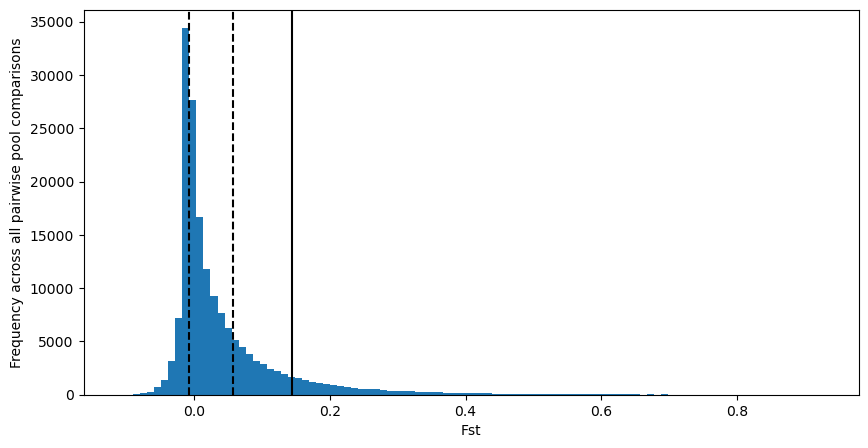

In [5]:
# distribution of Fst values across SNP positions and pairwise comparisons
fig,ax = plt.subplots(figsize = (10,5), facecolor = 'w')

ax.hist(data['multilocusfst'], bins=100)
ax.axvline(x = data['multilocusfst'].quantile(0.25), c = 'k', ls = '--')
ax.axvline(x = data['multilocusfst'].quantile(0.75), c = 'k', ls = '--')
ax.axvline(x = data['multilocusfst'].quantile(0.9), c = 'k')
plt.ylabel('Frequency across all pairwise pool comparisons')
plt.xlabel('Fst')
plt.show()

In [6]:
data['pair'].unique()

array(['pools12', 'pools13', 'pools14', 'pools23', 'pools24', 'pools34'],
      dtype=object)

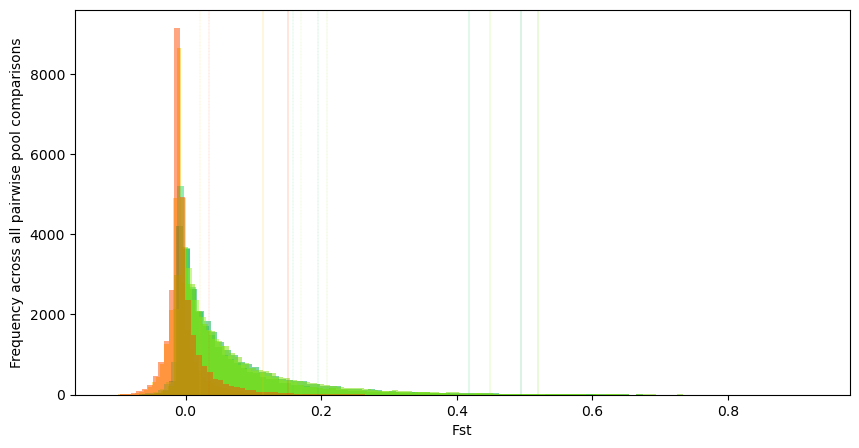

In [7]:
# colour dic with orange-hues for within morphotype comparisons and green-blue-ish hues for between morphotyes

paircol = {'pools12':'#FFC000',
           'pools13':'#24D86D',
           'pools14':'#00AC46',
           'pools23':'#98F229',
           'pools24':'#78DA00',
           'pools34':'#FF4C00'}

fig,ax = plt.subplots(figsize = (10,5), facecolor = 'w')

for pair in list(data['pair'].unique()):
    temp = data[data['pair'] == pair]
    ax.hist(temp['multilocusfst'], bins=100, color = paircol[pair], alpha = 0.5)
    ax.axvline(x = temp['multilocusfst'].quantile(0.90), c = paircol[pair], alpha = 0.6, ls = '--', lw = 0.2)
    ax.axvline(x = temp['multilocusfst'].quantile(0.99), c = paircol[pair], alpha = 1, lw = 0.2)
plt.ylabel('Frequency across all pairwise pool comparisons')
plt.xlabel('Fst')
plt.show()

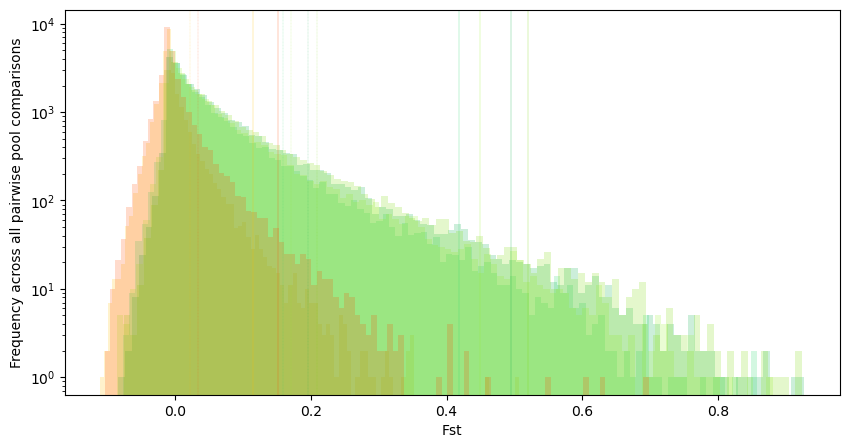

In [8]:
# colour dic with orange-hues for within morphotype comparisons and green-blue-ish hues for between morphotyes
fig,ax = plt.subplots(figsize = (10,5), facecolor = 'w')

for pair in list(data['pair'].unique()):
    temp = data[data['pair'] == pair]
    ax.hist(temp['multilocusfst'], bins=100, color = paircol[pair], alpha = 0.2, lw = 2)
    ax.axvline(x = temp['multilocusfst'].quantile(0.90), c = paircol[pair], alpha = 0.6, ls = '--', lw = 0.2)
    ax.axvline(x = temp['multilocusfst'].quantile(0.99), c = paircol[pair], alpha = 1, lw = 0.2)
ax.set_yscale('log')
plt.ylabel('Frequency across all pairwise pool comparisons')
plt.xlabel('Fst')
plt.show()

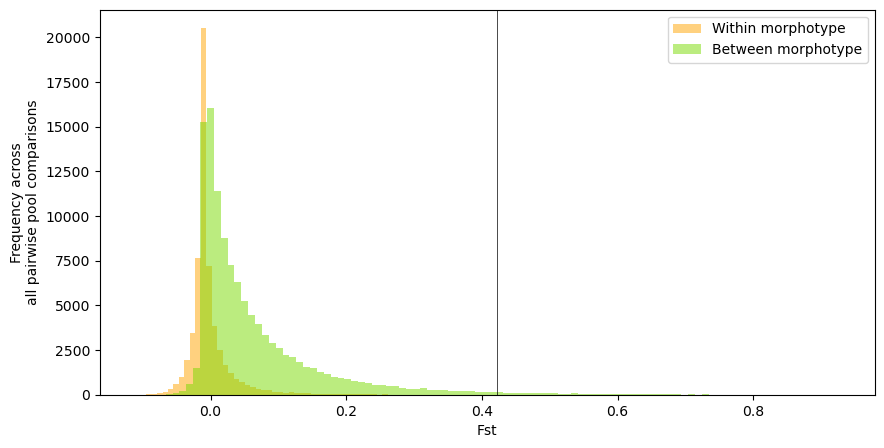

In [9]:
fig,ax = plt.subplots(figsize = (10,5), facecolor = 'w')

within = data[data['pair'].isin(['pools12','pools34'])]
between = data[data['pair'].isin(['pools13','pools14','pools23','pools24'])]

ax.hist(within['multilocusfst'], bins=100, color = '#FFA500', alpha = 0.5, label = 'Within morphotype')
ax.hist(between['multilocusfst'], bins=100, color = '#78DA00', alpha = 0.5, label = 'Between morphotype')

ax.axvline(x = data['multilocusfst'].quantile(0.99), c = 'k', alpha = 1, lw = 0.5)
plt.legend(loc = 'upper right', bbox_to_anchor = (0.5, 0.5, 0.5, 0.5))

plt.ylabel('Frequency across\nall pairwise pool comparisons')
plt.xlabel('Fst')
plt.show()

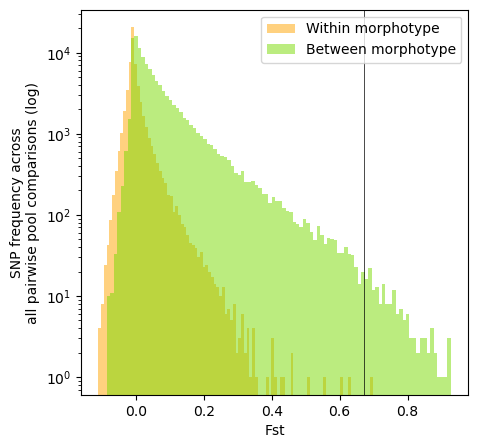

In [10]:
fig,ax = plt.subplots(figsize = (5,5), facecolor = 'w')

within = data[data['pair'].isin(['pools12','pools34'])]
between = data[data['pair'].isin(['pools13','pools14','pools23','pools24'])]

ax.hist(within['multilocusfst'], bins=100, color = '#FFA500', alpha = 0.5, label = 'Within morphotype')
ax.hist(between['multilocusfst'], bins=100, color = '#78DA00', alpha = 0.5, label = 'Between morphotype')

ax.axvline(x = data['multilocusfst'].quantile(0.999), c = 'k', alpha = 1, lw = 0.5)
ax.set_yscale('log')
plt.legend(loc = 'upper right', bbox_to_anchor = (0.5, 0.5, 0.5, 0.5))

plt.ylabel('SNP frequency across\nall pairwise pool comparisons (log)')
plt.xlabel('Fst')
plt.show()

In [11]:
print('Within Fst mean of %.3f and median of %.3f'%(within['multilocusfst'].mean(), within['multilocusfst'].median()))
print('Within Fst SD of %.3f'%(within['multilocusfst'].std()),'\n')

print('Between Fst mean of %.3f and median of %.3f'%(between['multilocusfst'].mean(), between['multilocusfst'].median()))
print('Between Fst SD of %.3f'%(between['multilocusfst'].std()),'\n')

Within Fst mean of -0.002 and median of -0.010
Within Fst SD of 0.033 

Between Fst mean of 0.065 and median of 0.029
Between Fst SD of 0.100 



# Number of SNPs between and within morphotype comparisons

Do we chose as outliers anything beyond 95% of the distribution? (Salazar et al.) or beyond 90%? or with Fst >0.9 independently of the data distribution?

It makes more sense to choose outliers based on the quantiles rather than a numberical threshold (e.g. quantile 0.999 vs. Fst value >0.9) since the numerical thershold might not have any biological relevance. More so if we are studying within species populations (or very closely related, diverging new species).

It also makes sense to estimate the quantile from the distribution of all (within and between morphotype) Fst values, this way we capture the wide variation when within and between population dynamycs are both present. e.g. If I use the 0.99 quantile for only within-morphotype comparisons to identify outliers in within-morphotype comparisons I will undoubtly find something. It is less obvious for using pairwise-specific quantiles when comparing between-morphotype pools though, but using a pairwise-specific quantile in this case also undoubtly result in outliers. It is better to use a more "independent" value.

### Global

In [12]:
# SNPs with Fst values between -0.1 and 0.1 - effectively not relevant at all
data[(data['multilocusfst'] > -0.1) & (data['multilocusfst'] < 0.1)].groupby('pair').count()

,index,chr,cumulatedposition,multilocusfst,position
pair,,,,,
pools12,28073,28073,28073,28073,28073
pools13,23172,23172,23172,23172,23172
pools14,21667,21667,21667,21667,21667
pools23,22643,22643,22643,22643,22643
pools24,21019,21019,21019,21019,21019
pools34,27761,27761,27761,27761,27761


In [13]:
# SNPs with Fst values below the 0.9 threshold - effectively not relevant
data[data['multilocusfst'] < 0.9].groupby('pair').count()

,index,chr,cumulatedposition,multilocusfst,position
pair,,,,,
pools12,28454,28454,28454,28454,28454
pools13,28457,28457,28457,28457,28457
pools14,28455,28455,28455,28455,28455
pools23,28457,28457,28457,28457,28457
pools24,28454,28454,28454,28454,28454
pools34,28456,28456,28456,28456,28456


In [14]:
# SNPs with Fst values above or equal to the 0.9 threshold - interesting to look at
data[data['multilocusfst'] >= 0.9].groupby('pair').count()

,index,chr,cumulatedposition,multilocusfst,position
pair,,,,,
pools14,2,2,2,2,2
pools24,3,3,3,3,3


In [15]:
p090 = data['multilocusfst'].quantile(0.90)
p095 = data['multilocusfst'].quantile(0.95)
p099 = data['multilocusfst'].quantile(0.99)
p0999 = data['multilocusfst'].quantile(0.999)


print('Threshold value for the 0.9 quantile: %.3f'%(p090))
print('Threshold value for the 0.95 quantile: %.3f'%(p095))
print('Threshold value for the 0.99 quantile: %.3f'%(p099))
print('Threshold value for the 0.999 quantile: %.3f'%(p0999))

Threshold value for the 0.9 quantile: 0.143
Threshold value for the 0.95 quantile: 0.220
Threshold value for the 0.99 quantile: 0.422
Threshold value for the 0.999 quantile: 0.672


In [16]:
data[data['multilocusfst'] >= p090].groupby('pair').count()

,index,chr,cumulatedposition,multilocusfst,position
pair,,,,,
pools12,151,151,151,151,151
pools13,3322,3322,3322,3322,3322
pools14,4542,4542,4542,4542,4542
pools23,3722,3722,3722,3722,3722
pools24,5009,5009,5009,5009,5009
pools34,328,328,328,328,328


In [17]:
data[data['multilocusfst'] >= p095].groupby('pair').count()

,index,chr,cumulatedposition,multilocusfst,position
pair,,,,,
pools12,40,40,40,40,40
pools13,1589,1589,1589,1589,1589
pools14,2317,2317,2317,2317,2317
pools23,1904,1904,1904,1904,1904
pools24,2596,2596,2596,2596,2596
pools34,91,91,91,91,91


In [18]:
data[data['multilocusfst'] >= p0999].groupby('pair').count()

,index,chr,cumulatedposition,multilocusfst,position
pair,,,,,
pools13,19,19,19,19,19
pools14,52,52,52,52,52
pools23,30,30,30,30,30
pools24,69,69,69,69,69
pools34,1,1,1,1,1


In [19]:
data.columns

Index(['index', 'chr', 'cumulatedposition', 'multilocusfst', 'pair',
       'position'],
      dtype='object')

### Quantile thresholds by pairwise comparison

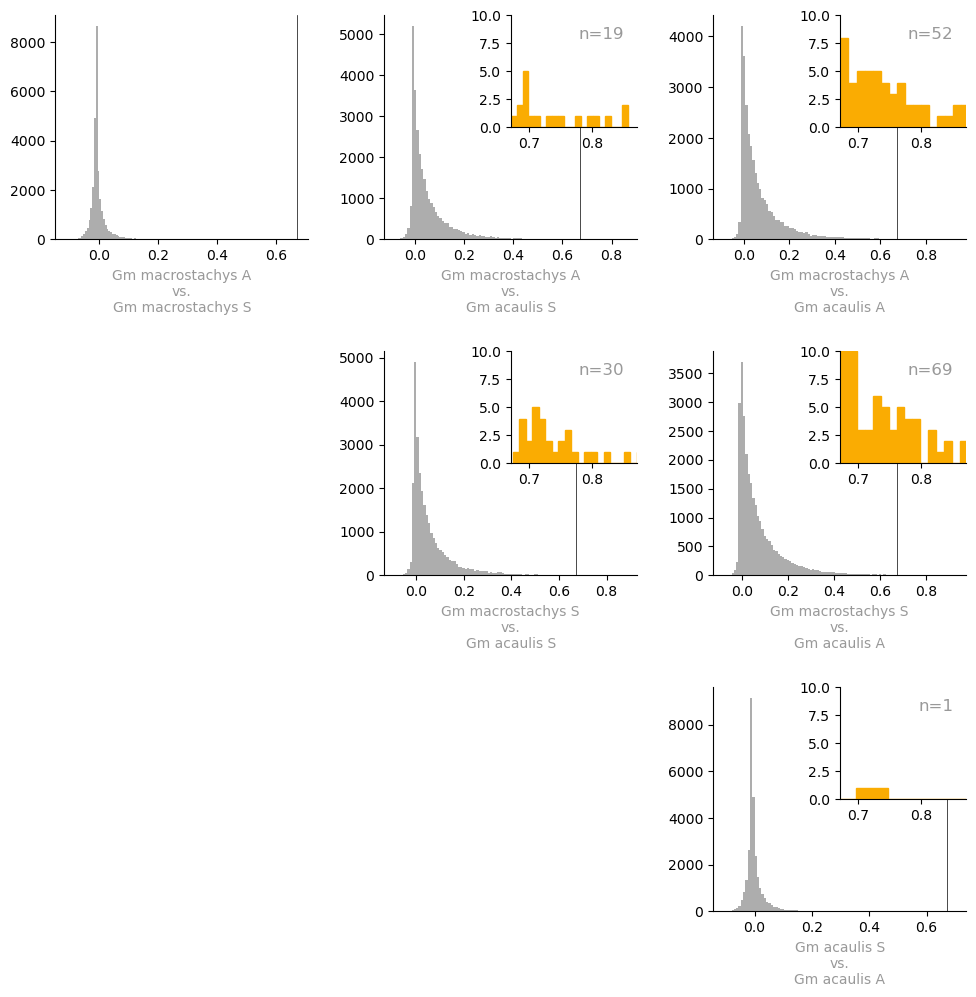

In [20]:
# we expect to find outliers in p1_p3, p2_p4, p1_p4, and p2_p3 that do not appear as outliers in p1_p2 or p3_p4
# we also need to understand the distribution of Fst values in each comparison

plt.figure(figsize=(4*4,4*4),facecolor='w')
G = gridspec.GridSpec(4,4,hspace=0.5,wspace=0.3)
spinescol='#999999'

labeldict = {'P13454_101':'Gm macrostachys A',
             'P13454_102':'Gm macrostachys S',
             'P13454_103':'Gm acaulis S',
             'P13454_104':'Gm acaulis A'}

plt.title('Distribution of pairwise Fst between pools')

alloutliers = pd.DataFrame(columns = ['index', 'chr', 'cumulatedposition', 'multilocusfst', 'pair', 'position'])

for x,y in combinations([i for i,x in enumerate(labeldict.keys())],2):
    ax = plt.subplot(G[x,y])
    temp = data[data['pair'] == 'pools%s%s'%(x+1,y+1)].copy(deep = True)
    outlier = temp[temp['multilocusfst'] >= p0999].copy(deep = True)
    alloutliers = pd.concat([alloutliers, outlier])
    
    ax.hist(data[data['pair'] == 'pools%s%s'%(x+1,y+1)]['multilocusfst'], bins = 100, color = '#adadad')      
    ax.axvline(x = p0999, c = 'k', alpha = 1, lw = 0.5)

    # I know, but I'm on a rush
    ax.set_xlabel('%s\nvs.\n%s'%(labeldict[list(labeldict.keys())[x]],labeldict[list(labeldict.keys())[y]]),
                  fontsize = 10, color = spinescol)

    [ax.spines[loc].set_visible(False) for loc in ['right','top']]

    if len(outlier) >= 1:
        ax1 = inset_axes(ax, width = '50%', height = '50%', loc = 1, borderpad = 0)
        ax1.hist(outlier['multilocusfst'], bins = 20, facecolor = '#faac02', edgecolor = '#faac02', lw = 1)
        ax1.set_ylim(0,10)
        ax1.set_xlim(p0999,p0999+0.2)
        ax1.vlines(x = 0.9, ymin = ax1.get_ylim()[0], ymax = ax1.get_ylim()[1], color = '#bababa', lw = 1)
        [ax1.spines[loc].set_visible(False) for loc in ['right','top']]

        ax1.text(0.9,0.9, s = 'n=%s'%(len(outlier)), fontsize = 12,ha='right',va='top', 
                 color = spinescol,transform=ax1.transAxes)

plt.show()

In [21]:
alloutliers.sort_values(['chr','cumulatedposition','pair'], inplace = True)
alloutliers.reset_index(inplace = True)
alloutliers

,level_0,index,chr,cumulatedposition,multilocusfst,pair,position
0,57749,835,NODE_103251_length_1585_cov_29.275817,48523738,0.731404,pools14,1472
1,114663,835,NODE_103251_length_1585_cov_29.275817,48523738,0.781356,pools24,1472
2,114664,836,NODE_103251_length_1585_cov_29.275817,48523767,0.691745,pools24,1501
3,86337,966,NODE_103957_length_1570_cov_25.852805,48630401,0.674653,pools23,1488
4,114883,1055,NODE_104226_length_1565_cov_22.646358,48689107,0.765209,pools24,1502
...,...,...,...,...,...,...,...
166,84402,27488,NODE_98688_length_1683_cov_23.089681,75982908,0.773380,pools14,1605
167,141316,27488,NODE_98688_length_1683_cov_23.089681,75982908,0.921059,pools24,1605
168,113559,28188,NW_011555567.1_RagTag_RagTag,84089756,0.719613,pools23,6271
169,142016,28188,NW_011555567.1_RagTag_RagTag,84089756,0.881519,pools24,6271


In [22]:
# alloutliers.to_csv('./GM_SNPs_Fst_2023/alloutliers_20230802.txt', sep = '\t')

In [23]:
alloutliers = pd.read_csv('./GM_SNPs_Fst_2023/alloutliers_20230802.txt', sep = '\t')
alloutliers.drop(columns = 'Unnamed: 0', inplace = True)
alloutliers

,level_0,index,chr,cumulatedposition,multilocusfst,pair,position
0,57749,835,NODE_103251_length_1585_cov_29.275817,48523738,0.731404,pools14,1472
1,114663,835,NODE_103251_length_1585_cov_29.275817,48523738,0.781356,pools24,1472
2,114664,836,NODE_103251_length_1585_cov_29.275817,48523767,0.691745,pools24,1501
3,86337,966,NODE_103957_length_1570_cov_25.852805,48630401,0.674653,pools23,1488
4,114883,1055,NODE_104226_length_1565_cov_22.646358,48689107,0.765209,pools24,1502
...,...,...,...,...,...,...,...
166,84402,27488,NODE_98688_length_1683_cov_23.089681,75982908,0.773380,pools14,1605
167,141316,27488,NODE_98688_length_1683_cov_23.089681,75982908,0.921059,pools24,1605
168,113559,28188,NW_011555567.1_RagTag_RagTag,84089756,0.719613,pools23,6271
169,142016,28188,NW_011555567.1_RagTag_RagTag,84089756,0.881519,pools24,6271


In [24]:
print('Total number of outliers: ',len(alloutliers['chr'].unique()),'\n')
print('Chromosomes with outliers: ',[x for x in list(alloutliers['chr'].unique()) if 'RagTag_RagTag' in str(x)])

Total number of outliers:  95 

Chromosomes with outliers:  ['NW_011555567.1_RagTag_RagTag', 'NW_011561999.1_RagTag_RagTag']


In [25]:
#cmap = mpl.colormaps['viridis'] # env. pandas21 pandas2.1
cmap = mpl.cm.viridis # env. genomics pandas1.2
norm = mpl.colors.Normalize(vmin = alloutliers['multilocusfst'].min(), vmax = alloutliers['multilocusfst'].max())
print(cmap(0.5))
print(norm(0.5))
print(cmap(norm((0.5))))

(0.127568, 0.566949, 0.550556, 1.0)
-0.6706241459598619
(0.267004, 0.004874, 0.329415, 1.0)


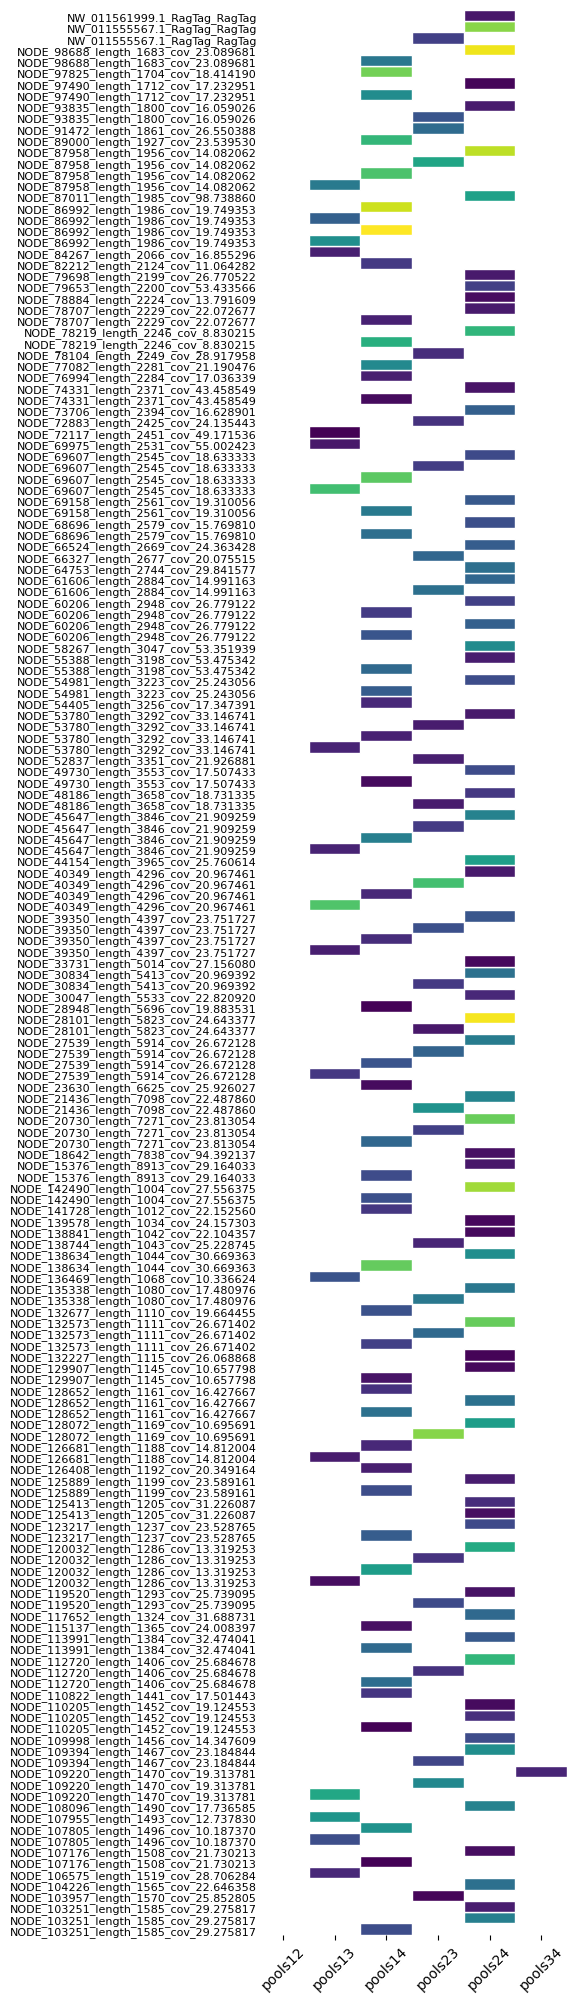

In [26]:
fig, ax = plt.subplots(figsize = (4,25), facecolor = 'w')

ax.set_ylim(0,len(alloutliers))
ax.set_xlim(0,len(data['pair'].unique()))

#cmap = mpl.colormaps['viridis'] # env. pandas21 pandas2.1
cmap = mpl.cm.viridis # env. genomics pandas1.2
norm = mpl.colors.Normalize(vmin = alloutliers['multilocusfst'].min(), vmax = alloutliers['multilocusfst'].max())

for x, pair in enumerate(data['pair'].unique()):
    temp = alloutliers[alloutliers['pair'] == pair]
    if len(temp) >= 1:
        for y in temp.index:
            ax.add_patch(mpl.patches.Rectangle((x, y), 1, 1, edgecolor = 'w',
                        facecolor = cmap(norm(temp.loc[y,'multilocusfst'])))) # (bottom,left), width, height

for index,chrm in enumerate(alloutliers['chr']):
    ax.text(x = 0, y = index, s = chrm, ha = 'right', fontsize = 8)
[ax.spines[loc].set_visible(False) for loc in ['right','top','left','bottom']]

ax.set_xticklabels(data['pair'].unique(), fontdict = {'fontsize': 10, 'rotation':45})
ax.set_xticks([x+0.5 for x,pair in enumerate(data['pair'].unique())])

plt.yticks([])
plt.show()

In [28]:
# make a list of the outlier loci that contains the chromosome info and the position
# alloutliers[['chr', 'position']].to_csv('./GM_SNPs_Fst_2023/outliers_0999_20230725.txt', sep ='\t')

In [34]:
%%bash
head ./GM_SNPs_Fst_2023/outliers_0999_20230725.txt

	chr	position
0	NODE_103251_length_1585_cov_29.275817	1472
1	NODE_103251_length_1585_cov_29.275817	1472
2	NODE_103251_length_1585_cov_29.275817	1501
3	NODE_103957_length_1570_cov_25.852805	1488
4	NODE_104226_length_1565_cov_22.646358	1502
5	NODE_106575_length_1519_cov_28.706284	1445
6	NODE_107176_length_1508_cov_21.730213	1465
7	NODE_107176_length_1508_cov_21.730213	1465
8	NODE_107805_length_1496_cov_10.187370	1423


In [31]:
# find sequences up and downstream from the SNPs in the reference sequence
toblast={}

for line in open('./GM_SNPs_Fst_2023/selected_contigs.fasta', 'r'):
    if '>' in line:
        if str(line).strip('\n').strip('>') in list(alloutliers['chr'].values):
            chrom = str(line).strip('\n').strip('>')

            poss = [x for x in set(alloutliers[alloutliers['chr'] == chrom]['position'].values)]
    # because there's no cases where a line with '>' won't be followed by a line without '>'
    # since the fasta sequence is a single line
    else:
        # here iterates through the different positions
        for pos in poss:
            toblast['%s_%s-1000'%(chrom,pos)] = line[pos-500:pos].strip('\n')+line[pos:pos+500].strip('\n')
            
            # note that a lot of the resulting sequences are shorter than 1000 nucleotides
            # because the SNPs are localted towards the end of the contig
            # contig data was filtered to remove contings shorter than 1000 nucleotides
            # print('\n',line[pos-500:pos].strip('\n')+'--SNP--'+line[pos:pos+500].strip('\n'))
#             print('\n',line,'\t')
#             print(len(line[pos-500:pos].strip('\n')), len(line[pos:pos+500].strip('\n')))
#             print(chrom ,len(line))

        poss = [] # empties the list
        chrom = []
# toblast

In [43]:
path = './GM_SNPs_Fst_2023/'
new_fasta = open(os.path.join(path,'SNP1000_wseqs.fasta'),'a')

for key,value in toblast.items():
    header = key # re.sub('_[0-9]+$','',key.split('-1000')[0])
    # print header
    new_fasta.write('>%s\n'%(header))
    # print sequence, line ending was removed already
    new_fasta.write('%s\n'%(value))
new_fasta.close()

In [ ]:
for contig,seq in toblast.items():
    if path.exists('./GM_SNPs_Fst_2023/results_blastn/%s_blastn_nt.xml'%(contig)) == True:
        print('Processed: ','./GM_SNPs_Fst_2023/results_blastn/%s_blastn_nt.xml'%(contig))
    else:
    
        result_handle = NCBIWWW.qblast('blastn', 'nt', seq, entrez_query = 'txid35493[ORGN]',
                                       alignments = 100, hitlist_size=100)
        print('Processing: ', contig)

        with open('./GM_SNPs_Fst_2023/results_blastn/%s_blastn_nt.xml'%(contig), 'w') as save_file:
            blast_results = result_handle.read() 
            save_file.write(blast_results)
            save_file.close()

            result_handle.close()
        time.sleep(0.5) # dont want to be kicked out  

In [ ]:
for contig,seq in toblast.items():
    if path.exists('./GM_SNPs_Fst_2023/results_blastx/%s_blastx_nr.xml'%(contig)) == True:
        print('Processed: ','./GM_SNPs_Fst_2023/results_blastx/%s_blastx_nr.xml'%(contig))
    else:
    
        result_handle = NCBIWWW.qblast('blastx', 'nr', seq, filter = 'txid35493[ORGN]', alignments = 100, hitlist_size=100)
        print('Processing: ', contig)

        with open('./GM_SNPs_Fst_2023/results_blastx/%s_blastx_nr.xml'%(contig), 'w') as save_file:
            blast_results = result_handle.read() 
            save_file.write(blast_results)
            save_file.close()

            result_handle.close()
        time.sleep(0.5) # dont want to be kicked out  

In [ ]:
%%bash
ls ./GM_SNPs_Fst_2023/results_blastn/

In [44]:
folder_path = './GM_SNPs_Fst_2023/results_blastn/'
prefix  ='*xml'

# iterate over files in
# that directory
columns = ['contig','result_id','hsp_id','hsp_evalue','hsp_bitscore','hsp_gapnum','hsp_range','hsp_description','hsp_pi']
blastnall = pd.DataFrame(columns = columns)

    
for filename in glob.glob(os.path.join(folder_path,'%s'%(prefix))):
#     print(filename)
    result = SearchIO.read(filename, 'blast-xml')
    
    contig = []
    result_id = []
    hsp_id = []
    hsp_evalue = []
    hsp_bitscore = []
    hsp_gapnum = []
    hsp_range = []
    hsp_description = []
    hsp_pi = []

    for hsp in result.hsps:
        if hsp.evalue < 0.00005:
            contig.append(filename.split('/')[-1].split('.xml')[0])
            result_id.append(result.blast_id)
            hsp_id.append(hsp.hit_id)
            hsp_evalue.append(hsp.evalue)
            hsp_bitscore.append(hsp.bitscore)
            hsp_gapnum.append(hsp.gap_num)
            hsp_range.append(hsp.hit_range)
            hsp_description.append(hsp.hit_description)
            hsp_pi.append(hsp.ident_num)
            
#             print(hsp_description)
#             time.sleep(0.5)
    if len(contig) >= 1:
        temp = pd.DataFrame(dict(zip(columns,
                                     [contig,result_id,hsp_id,hsp_evalue,hsp_bitscore,hsp_gapnum,hsp_range,hsp_description,hsp_pi])))
        blastnall = pd.concat([blastnall,temp])

blastnall

,contig,result_id,hsp_id,hsp_evalue,hsp_bitscore,hsp_gapnum,hsp_range,hsp_description,hsp_pi
0,NODE_107955_length_1493_cov_12.737830_1414-100...,Query_32277,gi|2306609436|emb|OX335795.1|,2.849580e-18,104.9800,8,"(630640, 630750)","Scutellaria galericulata genome assembly, chro...",94
1,NODE_107955_length_1493_cov_12.737830_1414-100...,Query_32277,gi|2306609436|emb|OX335795.1|,7.646480e-13,86.9463,0,"(632916, 632971)","Scutellaria galericulata genome assembly, chro...",52
2,NODE_107955_length_1493_cov_12.737830_1414-100...,Query_32277,gi|1477771530|gb|CP025657.1|,2.849580e-18,104.0780,0,"(1090965, 1091022)",Ipomoea trifida cultivar NCNSP0306 chromosome 14,57
3,NODE_107955_length_1493_cov_12.737830_1414-100...,Query_32277,gi|1477771530|gb|CP025657.1|,9.315310e-12,83.3396,0,"(480743, 480791)",Ipomoea trifida cultivar NCNSP0306 chromosome 14,47
4,NODE_107955_length_1493_cov_12.737830_1414-100...,Query_32277,gi|1477771528|gb|CP025655.1|,2.849580e-18,104.0780,0,"(18225893, 18225950)",Ipomoea trifida cultivar NCNSP0306 chromosome 12,57
...,...,...,...,...,...,...,...,...,...
1956,NW_011561999.1_RagTag_RagTag_10411-1000_blastn_nt,Query_27701,gi|2546768688|emb|OY288261.1|,8.611940e-06,63.5025,0,"(45542972, 45543069)","Agrostemma githago genome assembly, chromosome...",72
1957,NW_011561999.1_RagTag_RagTag_10411-1000_blastn_nt,Query_27701,gi|2546768688|emb|OY288261.1|,8.611940e-06,62.6008,2,"(17698799, 17698901)","Agrostemma githago genome assembly, chromosome...",77
1958,NW_011561999.1_RagTag_RagTag_10411-1000_blastn_nt,Query_27701,gi|2546768688|emb|OY288261.1|,8.611940e-06,62.6008,2,"(18679448, 18679550)","Agrostemma githago genome assembly, chromosome...",77
1959,NW_011561999.1_RagTag_RagTag_10411-1000_blastn_nt,Query_27701,gi|2546768688|emb|OY288261.1|,3.005860e-05,61.6992,4,"(4095293, 4095395)","Agrostemma githago genome assembly, chromosome...",77


In [47]:
# exploring the distribution of escores and bitscores
blastnall['hsp_ln'] = [x[1]-x[0] for x in blastnall['hsp_range']]
blastnall['hsp_gapnum'] = blastnall['hsp_gapnum'].astype('float')
blastnall['hsp_pi'] = blastnall['hsp_pi'].astype('float')

blastnall[['hsp_evalue','hsp_bitscore','hsp_gapnum','hsp_ln','hsp_pi']].describe()

,hsp_evalue,hsp_bitscore,hsp_gapnum,hsp_ln,hsp_pi
count,5.120200e+04,51202.000000,51202.000000,51202.000000,51202.000000
mean,1.504098e-06,115.928067,5.929124,336.009218,230.918363
std,5.793104e-06,47.838982,6.427143,170.245094,112.041730
min,0.000000e+00,60.797500,0.000000,34.000000,34.000000
25%,9.405820e-31,77.027800,0.000000,153.000000,113.000000
50%,9.817540e-18,102.275000,4.000000,339.000000,234.000000
75%,4.041360e-10,145.556000,9.000000,509.000000,343.000000
max,3.140540e-05,774.030000,65.000000,597.000000,529.000000


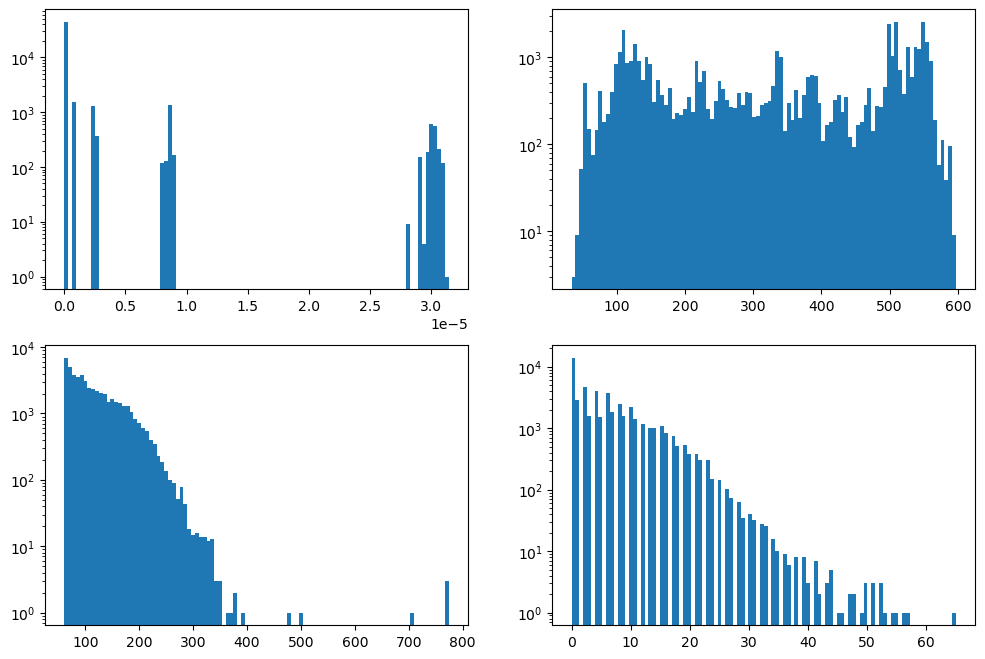

In [36]:
fix, axs = plt.subplots(2,2, figsize = (12,8), sharey=False, facecolor = 'w')

axs[0, 0].hist(blastnall['hsp_evalue'], bins = 100, log = True)
axs[1, 0].hist(blastnall['hsp_bitscore'], bins = 100, log = True)

axs[0, 1].hist([x[1]-x[0] for x in blastnall['hsp_range']],
               bins = 100, log = True)
axs[1, 1].hist(blastnall['hsp_gapnum'], bins = 100, log = True)

plt.show()

In [147]:
# we need to identify the best hit for each of the contigs
# the best is to sort values by evalue (ascending == true), length (asc = False), gaps (asc = True)
# then taking the first three records by contig and removing the rest

blastnall.sort_values(by = ['hsp_evalue','hsp_ln','hsp_gapnum'], ascending = [True, False, True]).reset_index(inplace = True)

# in case there are duplicates
blastnallfilt = blastnall.drop_duplicates(subset = ['contig','hsp_description','hsp_evalue'], keep = 'first')

best3blastn = pd.DataFrame(columns = blastnall.columns)

for contig in blastnallfilt['contig'].unique():
    temp = blastnallfilt[blastnallfilt['contig'] == contig].head(3)
    best3blastn = pd.concat([best3blastn, temp])

# uniqblastnall = blastnall.drop_duplicates(subset = 'contig', keep = 'first').reset_index()
# uniqblastnall
best3blastn

,contig,result_id,hsp_id,hsp_evalue,hsp_bitscore,hsp_gapnum,hsp_range,hsp_description,hsp_pi,hsp_ln
0,NODE_107955_length_1493_cov_12.737830_1414-100...,Query_32277,gi|2306609436|emb|OX335795.1|,2.849580e-18,104.9800,8.0,"(630640, 630750)","Scutellaria galericulata genome assembly, chro...",94.0,110
1,NODE_107955_length_1493_cov_12.737830_1414-100...,Query_32277,gi|2306609436|emb|OX335795.1|,7.646480e-13,86.9463,0.0,"(632916, 632971)","Scutellaria galericulata genome assembly, chro...",52.0,55
2,NODE_107955_length_1493_cov_12.737830_1414-100...,Query_32277,gi|1477771530|gb|CP025657.1|,2.849580e-18,104.0780,0.0,"(1090965, 1091022)",Ipomoea trifida cultivar NCNSP0306 chromosome 14,57.0,57
0,NODE_108096_length_1490_cov_17.736585_1407-100...,Query_26347,gi|1658070146|ref|XR_003799069.1|,3.054150e-100,376.3870,4.0,"(1874, 2244)",PREDICTED: Elaeis guineensis protein GLUTELIN ...,308.0,370
1,NODE_108096_length_1490_cov_17.736585_1407-100...,Query_26347,gi|1658070146|ref|XR_003799069.1|,5.190180e-15,94.1598,0.0,"(2231, 2320)",PREDICTED: Elaeis guineensis protein GLUTELIN ...,74.0,89
...,...,...,...,...,...,...,...,...,...,...
1,NODE_98688_length_1683_cov_23.089681_1605-1000...,Query_27599,gi|2546768122|emb|OY288240.1|,3.953460e-10,77.0278,6.0,"(11091861, 11092082)","Agrostemma githago genome assembly, chromosome: 2",152.0,221
2,NODE_98688_length_1683_cov_23.089681_1605-1000...,Query_27599,gi|2546768122|emb|OY288240.1|,4.816300e-09,74.3227,6.0,"(14625744, 14625966)","Agrostemma githago genome assembly, chromosome: 2",152.0,222
0,NW_011561999.1_RagTag_RagTag_10411-1000_blastn_nt,Query_27701,gi|1446104449|gb|MH680964.1|,1.893560e-39,175.3110,1.0,"(180013, 180434)",Phoenix dactylifera clone dpBLOGautosomal2 sex...,292.0,421
1,NW_011561999.1_RagTag_RagTag_10411-1000_blastn_nt,Query_27701,gi|1446107009|gb|MH681002.1|,3.423630e-36,164.4910,0.0,"(587515, 587968)",Phoenix dactylifera clone dpB2Y sex-determinat...,308.0,453


In [148]:
best3blastn[best3blastn['contig'].str.contains('Rag')]

,contig,result_id,hsp_id,hsp_evalue,hsp_bitscore,hsp_gapnum,hsp_range,hsp_description,hsp_pi,hsp_ln
0,NW_011561999.1_RagTag_RagTag_10411-1000_blastn_nt,Query_27701,gi|1446104449|gb|MH680964.1|,1.893560e-39,175.311,1.0,"(180013, 180434)",Phoenix dactylifera clone dpBLOGautosomal2 sex...,292.0,421
1,NW_011561999.1_RagTag_RagTag_10411-1000_blastn_nt,Query_27701,gi|1446107009|gb|MH681002.1|,3.423630e-36,164.491,0.0,"(587515, 587968)",Phoenix dactylifera clone dpB2Y sex-determinat...,308.0,453
2,NW_011561999.1_RagTag_RagTag_10411-1000_blastn_nt,Query_27701,gi|1964241594|ref|XM_039117824.1|,2.632090e-31,148.261,0.0,"(1173, 1567)",PREDICTED: Phoenix dactylifera uncharacterized...,269.0,394


In [38]:
# best3blastn[['contig','hsp_description', 'hsp_evalue']].sort_values(by = 'hsp_evalue', ascending = True)
best3blastn.sort_values(by = 'hsp_evalue', ascending = True)['hsp_description'].values

array(['PREDICTED: Elaeis guineensis probable LRR receptor-like serine/threonine-protein kinase At3g47570 (LOC105036214), transcript variant X2, mRNA',
       'PREDICTED: Elaeis guineensis probable LRR receptor-like serine/threonine-protein kinase At3g47570 (LOC105036214), transcript variant X1, mRNA',
       'PREDICTED: Elaeis guineensis probable LRR receptor-like serine/threonine-protein kinase At3g47570 (LOC105032866), mRNA',
       'PREDICTED: Elaeis guineensis protein GLUTELIN PRECURSOR ACCUMULATION 3 (LOC105034327), transcript variant X2, misc_RNA',
       'PREDICTED: Elaeis guineensis protein GLUTELIN PRECURSOR ACCUMULATION 3 (LOC105034327), transcript variant X1, misc_RNA',
       'Ananas comosus genome assembly, chromosome: 18',
       'Ananas comosus var. bracteatus genome assembly, chromosome: 18',
       'Quercus robur genome assembly, chromosome: 5',
       'Quercus robur genome assembly, chromosome: 10',
       'Quercus robur genome assembly, chromosome: 5',
       'Querc

In [42]:
best3blastn['hsp_id'].str.split('|')

0        [gi, 2306609436, emb, OX335795.1, ]
1        [gi, 2306609436, emb, OX335795.1, ]
2         [gi, 1477771530, gb, CP025657.1, ]
0    [gi, 1658070146, ref, XR_003799069.1, ]
1    [gi, 1658070146, ref, XR_003799069.1, ]
                      ...                   
1        [gi, 2546768122, emb, OY288240.1, ]
2        [gi, 2546768122, emb, OY288240.1, ]
0         [gi, 1446104449, gb, MH680964.1, ]
1         [gi, 1446107009, gb, MH681002.1, ]
2    [gi, 1964241594, ref, XM_039117824.1, ]
Name: hsp_id, Length: 121, dtype: object

In [57]:
best3blastn.to_csv('./GM_SNPs_Fst_2023/results_blastn/best_hsps_contigs_blastn_20230802.txt', sep = '\t')

In [25]:
folder_path = './GM_SNPs_Fst_2023/results_blastx/'
prefix  ='*xml'

# iterate over files in
# that directory
columns = ['contig','result_id','hsp_id','hsp_evalue','hsp_bitscore','hsp_gapnum','hsp_range','hsp_description','hsp_pi']
blastxall = pd.DataFrame(columns = columns)

    
for filename in glob.glob(os.path.join(folder_path,'%s'%(prefix))):
#     print(filename)
    result = SearchIO.read(filename, 'blast-xml')
    
    contig = []
    result_id = []
    hsp_id = []
    hsp_evalue = []
    hsp_bitscore = []
    hsp_gapnum = []
    hsp_range = []
    hsp_description = []
    hsp_pi = []

    for hsp in result.hsps:
        if hsp.evalue < 0.00005:
            contig.append(filename.split('/')[-1].split('.xml')[0])
            result_id.append(result.blast_id)
            hsp_id.append(hsp.hit_id)
            hsp_evalue.append(hsp.evalue)
            hsp_bitscore.append(hsp.bitscore)
            hsp_gapnum.append(hsp.gap_num)
            hsp_range.append(hsp.hit_range)
            hsp_description.append(hsp.hit_description)
            hsp_pi.append(hsp.ident_num) # number of identical residues in alignment
            
#             print(hsp_description)
#             time.sleep(0.5)
    if len(contig) >= 1:
        temp = pd.DataFrame(dict(zip(columns,
                                     [contig,result_id,hsp_id,hsp_evalue,hsp_bitscore,hsp_gapnum,hsp_range,hsp_description,hsp_pi])))
        blastxall = pd.concat([blastxall,temp])

blastxall

/home/mft/.local/lib/python3.8/site-packages/biopython-1.81-py3.8-linux-x86_64.egg/Bio/SearchIO/_legacy/__init__.py:12: BiopythonDeprecationWarning: The 'Bio.SearchIO._legacy' module for parsing BLAST plain text output is deprecated and will be removed in a future release of Biopython. Consider generating your BLAST output for parsing as XML or tabular format instead.
  warnings.warn(


,contig,result_id,hsp_id,hsp_evalue,hsp_bitscore,hsp_gapnum,hsp_range,hsp_description,hsp_pi
0,NODE_108096_length_1490_cov_17.736585_1407-100...,Query_4787,ref|XP_057955072.1|,7.310400e-09,56.6102,5,"(10, 78)",uncharacterized protein LOC131149045 [Malania ...,31
1,NODE_108096_length_1490_cov_17.736585_1407-100...,Query_4787,ref|XP_057955072.1|,7.310400e-09,33.1130,8,"(77, 121)",uncharacterized protein LOC131149045 [Malania ...,16
2,NODE_108096_length_1490_cov_17.736585_1407-100...,Query_4787,ref|XP_010914753.1|,1.725080e-07,51.2174,0,"(4, 55)",uncharacterized protein LOC105040079 [Elaeis g...,19
3,NODE_108096_length_1490_cov_17.736585_1407-100...,Query_4787,ref|XP_010914753.1|,1.725080e-07,33.8834,0,"(56, 86)",uncharacterized protein LOC105040079 [Elaeis g...,13
4,NODE_108096_length_1490_cov_17.736585_1407-100...,Query_4787,ref|XP_057966041.1|,6.493370e-07,51.6026,5,"(10, 83)",uncharacterized protein LOC131156404 [Malania ...,30
...,...,...,...,...,...,...,...,...,...
96,NW_011561999.1_RagTag_RagTag_10411-1000_blastx_nr,Query_9483,ref|XP_009413782.1|,7.901350e-65,228.0240,0,"(1392, 1582)",PREDICTED: uncharacterized protein LOC10399502...,107
97,NW_011561999.1_RagTag_RagTag_10411-1000_blastx_nr,Query_9483,gb|KAJ4715162.1|,8.361040e-65,227.6390,0,"(1356, 1546)",Retrovirus-related Pol polyprotein from transp...,104
98,NW_011561999.1_RagTag_RagTag_10411-1000_blastx_nr,Query_9483,ref|XP_030941624.1|,8.738500e-65,216.8530,0,"(260, 449)",uncharacterized protein LOC115966552 [Quercus ...,100
99,NW_011561999.1_RagTag_RagTag_10411-1000_blastx_nr,Query_9483,dbj|GMH25591.1|,9.759810e-65,220.7050,0,"(235, 425)",hypothetical protein Nepgr_027434 [Nepenthes g...,101


In [26]:
# exploring the distribution of escores and bitscores
blastxall['hsp_ln'] = [x[1]-x[0] for x in blastxall['hsp_range']]
blastxall['hsp_gapnum'] = blastxall['hsp_gapnum'].astype('float')
blastxall['hsp_pi'] = blastxall['hsp_pi'].astype('float')

blastxall[['hsp_evalue','hsp_bitscore','hsp_gapnum','hsp_ln','hsp_pi']].describe()

,hsp_evalue,hsp_bitscore,hsp_gapnum,hsp_ln,hsp_pi
count,4.001000e+03,4001.000000,4001.000000,4001.000000,4001.000000
mean,9.714442e-07,121.355863,4.672832,129.340165,62.002000
std,5.112506e-06,70.363424,7.511470,52.174112,32.064872
min,1.718560e-97,20.786600,0.000000,13.000000,9.000000
25%,1.331560e-49,64.314200,0.000000,77.000000,35.000000
50%,4.340720e-26,100.138000,1.000000,140.000000,54.000000
75%,3.477020e-14,168.318000,6.000000,182.000000,88.000000
max,4.993380e-05,315.464000,56.000000,218.000000,165.000000


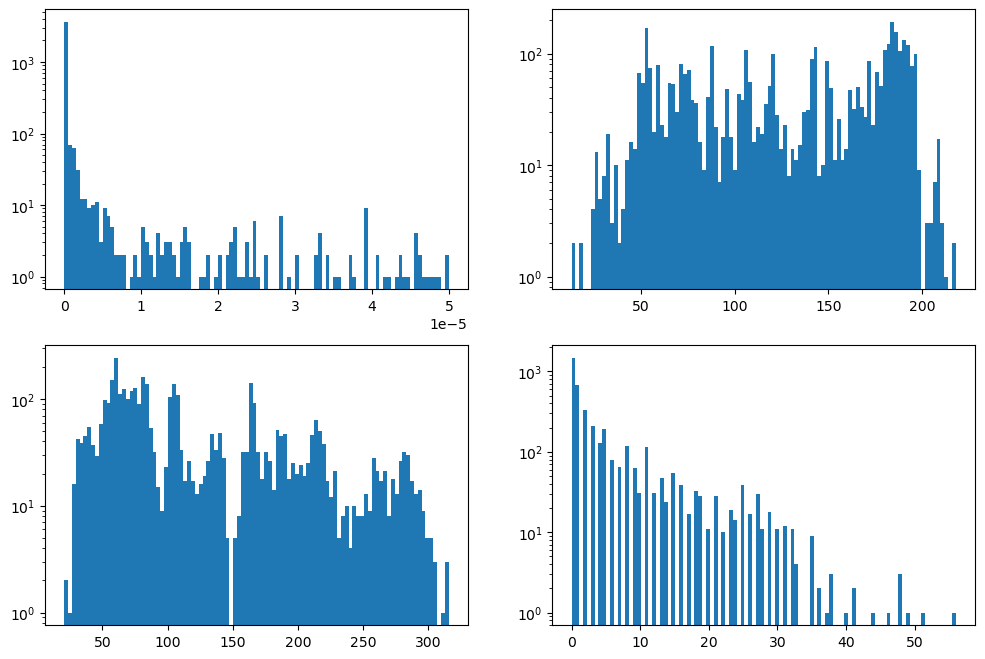

In [27]:
fix, axs = plt.subplots(2,2, figsize = (12,8), sharey=False, facecolor = 'w')

axs[0, 0].hist(blastxall['hsp_evalue'], bins = 100, log = True)
axs[1, 0].hist(blastxall['hsp_bitscore'], bins = 100, log = True)

axs[0, 1].hist([x[1]-x[0] for x in blastxall['hsp_range']],
               bins = 100, log = True)
axs[1, 1].hist(blastxall['hsp_gapnum'], bins = 100, log = True)

plt.show()

In [29]:
# we need to identify the best hit for each of the contigs
# the best is to sort values by evalue (ascending == true), length (asc = False), gaps (asc = True)
# then taking the first three records by contig and removing the rest

blastxall.sort_values(by = ['hsp_evalue','hsp_ln','hsp_gapnum'], ascending = [True, False, True]).reset_index(inplace = True)

# in case there are duplicates
blastxallfilt = blastxall.drop_duplicates(subset = ['contig','hsp_description','hsp_evalue'], keep = 'first')

best3blastx = pd.DataFrame(columns = blastxall.columns)

for contig in blastxallfilt['contig'].unique():
    temp = blastxallfilt[blastxallfilt['contig'] == contig].head(3)
    best3blastx = pd.concat([best3blastx, temp])

# uniqblastnall = blastnall.drop_duplicates(subset = 'contig', keep = 'first').reset_index()
# uniqblastnall
best3blastx

,contig,result_id,hsp_id,hsp_evalue,hsp_bitscore,hsp_gapnum,hsp_range,hsp_description,hsp_pi,hsp_ln
0,NODE_108096_length_1490_cov_17.736585_1407-100...,Query_4787,ref|XP_057955072.1|,7.310400e-09,56.6102,5.0,"(10, 78)",uncharacterized protein LOC131149045 [Malania ...,31.0,68
2,NODE_108096_length_1490_cov_17.736585_1407-100...,Query_4787,ref|XP_010914753.1|,1.725080e-07,51.2174,0.0,"(4, 55)",uncharacterized protein LOC105040079 [Elaeis g...,19.0,51
4,NODE_108096_length_1490_cov_17.736585_1407-100...,Query_4787,ref|XP_057966041.1|,6.493370e-07,51.6026,5.0,"(10, 83)",uncharacterized protein LOC131156404 [Malania ...,30.0,73
0,NODE_109220_length_1470_cov_19.313781_1388-100...,Query_103961,gb|KAG1368370.1|,2.408330e-11,73.9442,3.0,"(1, 103)",hypothetical protein COCNU_14G008380 [Cocos nu...,41.0,102
1,NODE_109220_length_1470_cov_19.313781_1388-100...,Query_103961,ref|XP_029123308.1|,1.147690e-10,72.0182,5.0,"(135, 237)",uncharacterized protein LOC114914669 [Elaeis g...,41.0,102
...,...,...,...,...,...,...,...,...,...,...
1,NODE_98688_length_1683_cov_23.089681_1605-1000...,Query_26253,gb|KAG1359359.1|,1.273300e-59,213.0010,0.0,"(777, 964)",hypothetical protein COCNU_08G008050 [Cocos nu...,107.0,187
2,NODE_98688_length_1683_cov_23.089681_1605-1000...,Query_26253,gb|EHA8589492.1|,1.297990e-59,213.0010,0.0,"(653, 840)",hypothetical protein [Cocos nucifera],107.0,187
0,NW_011561999.1_RagTag_RagTag_10411-1000_blastx_nr,Query_9483,gb|KAG1358790.1|,1.622250e-82,263.4620,0.0,"(114, 304)",putative Rve domain-containing protein [Cocos ...,121.0,190
1,NW_011561999.1_RagTag_RagTag_10411-1000_blastx_nr,Query_9483,gb|KAG1359359.1|,4.031720e-78,265.3880,0.0,"(958, 1148)",hypothetical protein COCNU_08G008050 [Cocos nu...,121.0,190


In [30]:
best3blastx.sort_values(by = 'hsp_evalue', ascending = True)['hsp_description'].values

array(['probable LRR receptor-like serine/threonine-protein kinase At3g47570 [Elaeis guineensis]',
       'hypothetical protein KFK09_018050 [Dendrobium nobile]',
       'RNA-directed DNA polymerase [Dendrobium catenatum]',
       'hypothetical protein [Cocos nucifera]',
       'hypothetical protein COCNU_11G005880 [Cocos nucifera]',
       'RNA-directed DNA polymerase [Dendrobium catenatum]',
       'putative RVT_1 domain-containing protein [Cocos nucifera]',
       'hypothetical protein COCNU_08G008050 [Cocos nucifera]',
       'hypothetical protein [Cocos nucifera]',
       'hypothetical protein COCNU_08G008050 [Cocos nucifera]',
       'putative Rve domain-containing protein [Cocos nucifera]',
       'hypothetical protein COCNU_08G008050 [Cocos nucifera]',
       'hypothetical protein [Cocos nucifera]',
       'uncharacterized protein LOC115950037 [Quercus lobata]',
       'uncharacterized protein LOC126710116 [Quercus robur]',
       'uncharacterized protein LOC126728462 [Quercus 

In [31]:
best3blastx.to_csv('./GM_SNPs_Fst_2023/results_blastx/best_hsps_contigs_blastx_20230802.txt', sep = '\t')

# Plotting SNP presence and best blastn hit description

In [27]:
best_hspblastn_annot = pd.read_csv('./GM_SNPs_Fst_2023/results_blastn/best_hsps_contigs_blastn_annotated_20230802.txt', sep = '\t')
blastn_best = best_hspblastn_annot.drop(columns = ['index']).sort_values(by=['contig','hsp_evalue'], ascending = [True, True]).drop_duplicates(subset = 'contig', keep = 'first').reset_index()
blastn_best['contig'] = blastn_best['contig'].str.replace('_[0-9]+-1000_blastn_nt','', regex = True)
blastn_best

,index,contig,result_id,hsp_id,hsp_evalue,hsp_bitscore,hsp_gapnum,hsp_range,plt_tittle,hsp_description,hsp_ln
0,44,NODE_107955_length_1493_cov_12.737830,Query_32277,gi|1477771530|gb|CP025657.1|,2.850000e-18,104.0780,0,"(1090965, 1091022)",Genomic region,Ipomoea trifida cultivar NCNSP0306 chromosome 14,57
1,77,NODE_108096_length_1490_cov_17.736585,Query_26347,gi|1658070144|ref|XR_003799068.1|,3.050000e-100,376.3870,4,"(1877, 2247)",miscRNA protein glutelin precursor accumulation 3,PREDICTED: Elaeis guineensis protein GLUTELIN ...,370
2,82,NODE_109394_length_1467_cov_23.184844,Query_43375,gi|743877152|ref|XM_010909507.1|,4.190000e-16,97.7665,5,"(333, 517)",mRNA uncharacterized GeneID 105034373,PREDICTED: Elaeis guineensis uncharacterized L...,184
3,47,NODE_110822_length_1441_cov_17.501443,Query_46985,gi|2245155233|gb|CP097503.1|,2.440000e-06,65.3059,2,"(3183921, 3184013)",Genomic region,Musa troglodytarum cultivar karat chromosome 10,92
4,11,NODE_112720_length_1406_cov_25.684678,Query_105935,gi|1885279427|emb|LR862151.1|,1.560000e-59,242.0360,11,"(7951320, 7951618)",Genomic region,Ananas comosus var. bracteatus genome assembly...,298
5,114,NODE_115137_length_1365_cov_24.008397,Query_26017,gi|2519850226|emb|OX596235.1|,4.590000e-09,74.3227,9,"(25718598, 25718723)",Genomic region,"Salicornia ramosissima genome assembly, chromo...",125
6,41,NODE_117652_length_1324_cov_31.688731,Query_93929,gi|2510678783|emb|OX637396.1|,1.700000e-08,72.5194,2,"(7240274, 7240399)",Genomic region,"Ilex aquifolium genome assembly, chromosome: 6",125
7,106,NODE_119520_length_1293_cov_25.739095,Query_23171,gi|2542043334|gb|CP129434.1|,2.910000e-24,123.9150,2,"(4662367, 4662738)",Genomic region,Quercus variabilis isolate HB chromosome 2b,371
8,69,NODE_125889_length_1199_cov_23.589161,Query_13531,gi|2526840264|ref|XM_057629090.1|,3.030000e-24,124.8170,1,"(4572, 4864)",mRNA uncharacterized GeneID 130771473,PREDICTED: Actinidia eriantha uncharacterized ...,292
9,74,NODE_126408_length_1192_cov_20.349164,Query_542951,gi|1658064177|ref|XM_010907448.3|,0.000000e+00,774.0300,0,"(260, 856)",mRNA LRR receptor-like serine/threonine-protei...,PREDICTED: Elaeis guineensis probable LRR rece...,596


In [28]:
# dictionary contains the best hit titles from blastn searches. built from the best hit table a few cells above.
# if the contig is not in this dic is because the blatn hit didnt pass the filters for significance
contig_annot = dict(zip(blastn_best['contig'],blastn_best['plt_tittle']))

pool_names = {'pools12': 'macA vs macS',
              'pools23': 'macS vs acaS',
              'pools24': 'macS vs acaA',
              'pools13': 'macA vs acaS',
              'pools14': 'macA vs acaA',
              'pools34': 'acaS vs acaA'}

In [29]:
ybase_contig = {chrom:index for index,chrom in enumerate(alloutliers['chr'].unique())}
# ybase_contig

In [30]:
print('Number of SNPs that have outlier Fst values in at least one pairwise pool comparison:\n',len(ybase_contig.keys()))

Number of SNPs that have outlier Fst values in at least one pairwise pool comparison:
 95


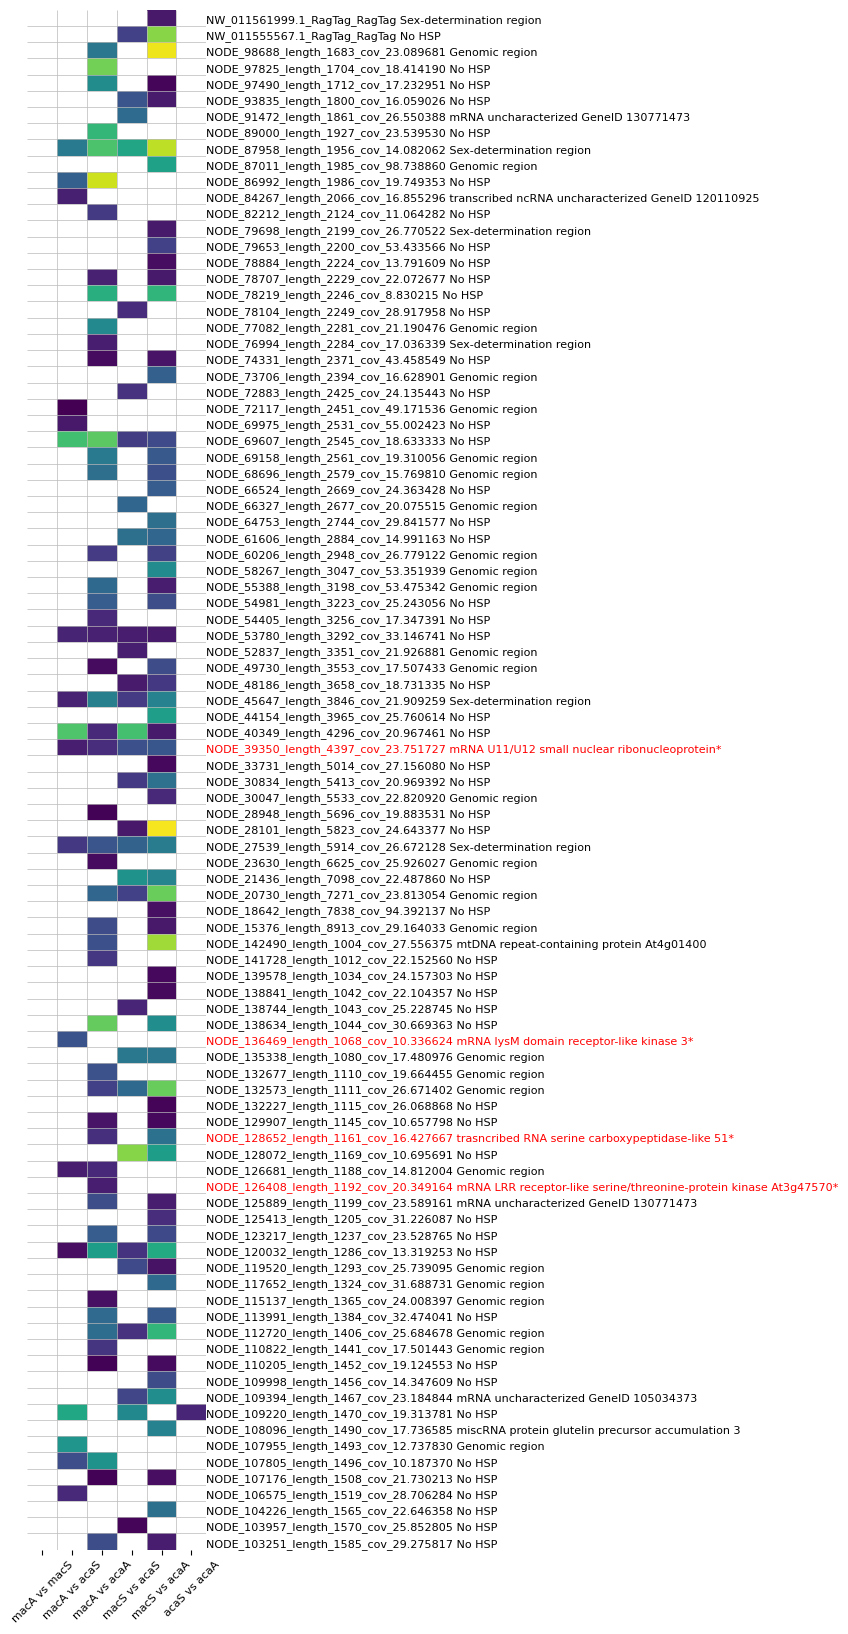

In [31]:
# no hsp means that blastn results didnt return significant hits, mostly short fragments with evalues larger than 0e-5

fig, ax = plt.subplots(figsize = (2.5,20), facecolor = 'w')

spinecol = '#bababa'

ax.set_ylim(0,len(ybase_contig))
ax.set_xlim(-0.5,len(data['pair'].unique()))

cmap = mpl.cm.get_cmap('viridis')
norm = mpl.colors.Normalize(vmin = alloutliers['multilocusfst'].min(), vmax = alloutliers['multilocusfst'].max())

for x, pair in enumerate(data['pair'].unique()):
    temp = alloutliers[alloutliers['pair'] == pair]
    if len(temp) >= 1:
        for y in temp.index:
            contig = temp.loc[y,'chr']
            # this is plotting the patches by contig, with the contigs with largest indices (y coordinate) at the top of the plot
            ax.add_patch(mpl.patches.Rectangle((x, ybase_contig[contig]), 1, 1, edgecolor = 'none',
                        facecolor = cmap(norm(temp.loc[y,'multilocusfst'])))) # (bottom,left), width, height
    ax.vlines(x = x+1, ymin = 0, ymax = ax.get_ylim()[1], lw = 0.5, color = spinecol)

for index,chrm in enumerate(alloutliers['chr'].unique()):
#     print('>>%s<<'%(contig_annot[chrm] if chrm in contig_annot.keys() else 'No HSP'))
    # using the dictionary to access y coordinates for the contig+annotation to make sure the annotation corresponds to the correct contig
    ax.text(x = 6, y = ybase_contig[chrm] + 0.2, s = '%s %s'%(chrm,contig_annot[chrm] if chrm in contig_annot.keys() else 'No HSP'),
            ha = 'left', fontsize = 8, color = 'r' if chrm in contig_annot.keys() and '*' in contig_annot[chrm] else 'k')
    ax.hlines(y = index, xmin = 0, xmax = ax.get_xlim()[1], lw = 0.5, color = spinecol)

[ax.spines[loc].set_visible(False) for loc in ['right','top','left','bottom']]

ax.set_xticklabels([pool_names[name] for name in data['pair'].unique()], fontdict = {'fontsize': 8, 'rotation':45})
ax.set_xticks([x+0.5 for x,pair in enumerate(data['pair'].unique())])


plt.yticks([])
plt.show()

In [36]:
best_hspblastn_annot[best_hspblastn_annot['contig'].str.contains('NODE_126408_length_1192_cov_20.349164')]['plt_tittle'].values

array(['mRNA LRR receptor-like serine/threonine-protein kinase At3g47570*',
       'mRNA LRR receptor-like serine/threonine-protein kinase At3g47570*',
       'mRNA LRR receptor-like serine/threonine-protein kinase At3g47570*'],
      dtype=object)

In [37]:
alloutliers[alloutliers['chr'].str.contains('NODE_126408_length_1192_cov_20.349164')]

,level_0,index,chr,cumulatedposition,multilocusfst,pair,position
41,64106,7192,NODE_126408_length_1192_cov_20.349164,52478957,0.692968,pools14,1096


# Plotting SNP presence and best blastx hit description

In [32]:
best_hspblastx_annot = pd.read_csv('./GM_SNPs_Fst_2023/results_blastx/best_hsps_contigs_blastx_annotated_20230802.txt', sep = '\t')
blastx_best = best_hspblastx_annot.drop(columns = ['index']).sort_values(by=['contig','hsp_evalue'], ascending = [True,True]).drop_duplicates(subset = 'contig', keep = 'first').reset_index()
print(blastx_best[blastx_best['contig'].str.contains('NW')]['contig'])
print(len(blastx_best))
blastx_best['contig'] = blastx_best['contig'].str.replace('_[0-9]+-1000_blastx_nr','', regex = True)
blastx_best['contig'].unique()
# blastx_best

38    NW_011561999.1_RagTag_RagTag_10411-1000_blastx_nr
Name: contig, dtype: object
39


array(['NODE_108096_length_1490_cov_17.736585',
       'NODE_109220_length_1470_cov_19.313781',
       'NODE_109394_length_1467_cov_23.184844',
       'NODE_112720_length_1406_cov_25.684678',
       'NODE_117652_length_1324_cov_31.688731',
       'NODE_119520_length_1293_cov_25.739095',
       'NODE_120032_length_1286_cov_13.319253',
       'NODE_123217_length_1237_cov_23.528765',
       'NODE_125889_length_1199_cov_23.589161',
       'NODE_126408_length_1192_cov_20.349164',
       'NODE_126681_length_1188_cov_14.812004',
       'NODE_132573_length_1111_cov_26.671402',
       'NODE_132677_length_1110_cov_19.664455',
       'NODE_135338_length_1080_cov_17.480976',
       'NODE_138634_length_1044_cov_30.669363',
       'NODE_142490_length_1004_cov_27.556375',
       'NODE_20730_length_7271_cov_23.813054',
       'NODE_21436_length_7098_cov_22.487860',
       'NODE_27539_length_5914_cov_26.672128',
       'NODE_30047_length_5533_cov_22.820920',
       'NODE_39350_length_4397_cov_23.751727

In [122]:
contig_annot = dict(zip(blastx_best['contig'],blastx_best['plot_tittle']))

pool_names = {'pools12': 'macA vs macS',
              'pools23': 'macS vs acaS',
              'pools24': 'macS vs acaA',
              'pools13': 'macA vs acaS',
              'pools14': 'macA vs acaA',
              'pools34': 'acaS vs acaA'}

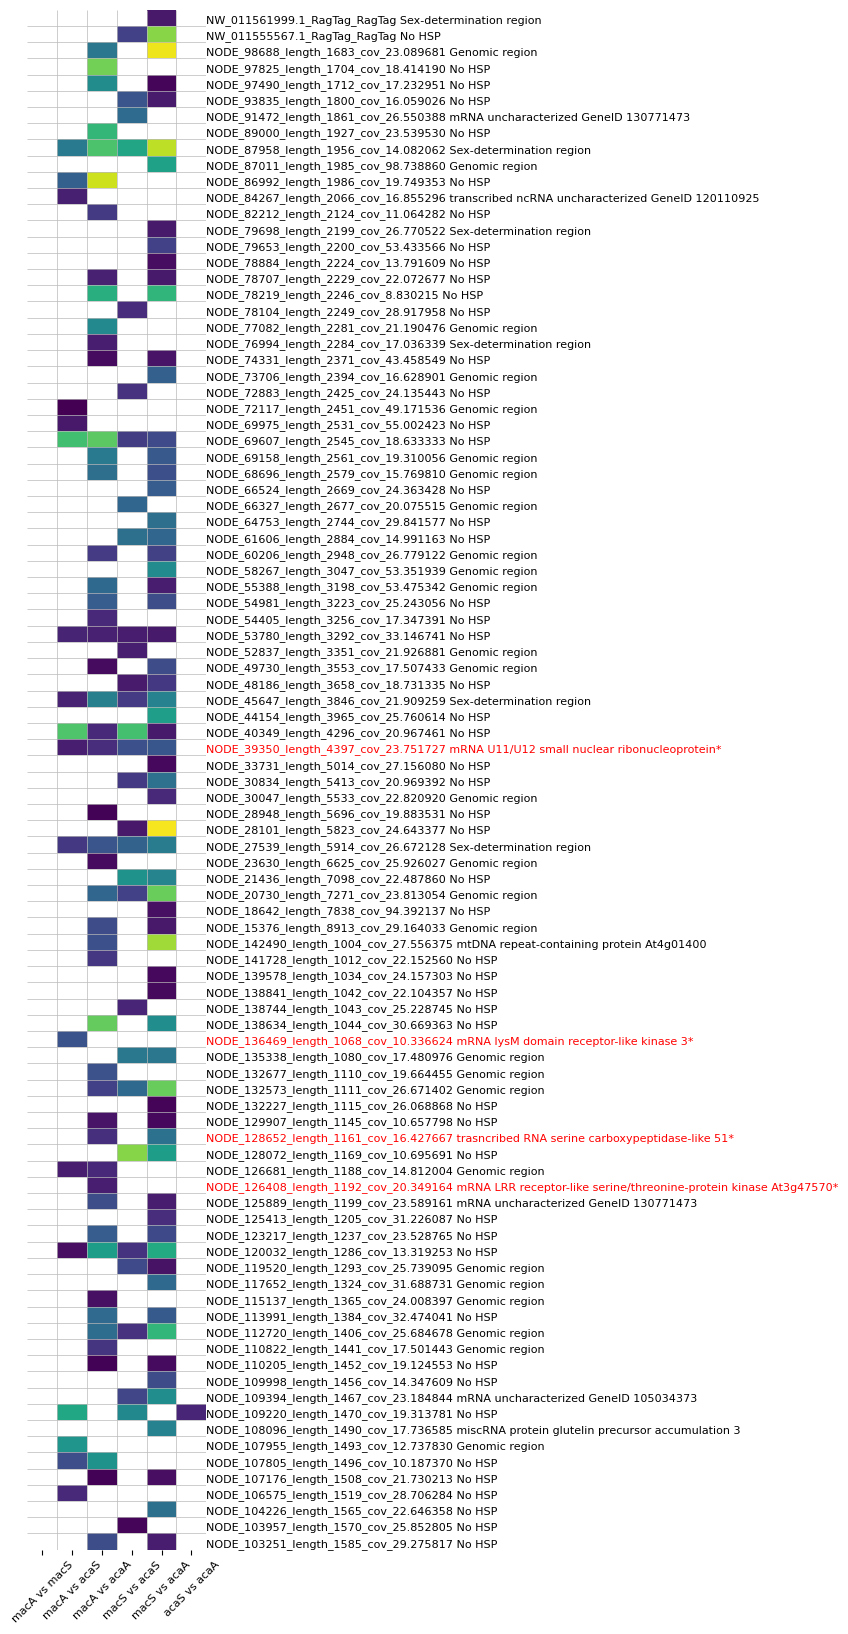

In [33]:
# no hsp means that blastn results didnt return significant hits, mostly short fragments with evalues larger than 0e-5

fig, ax = plt.subplots(figsize = (2.5,20), facecolor = 'w')

spinecol = '#bababa'

ax.set_ylim(0,len(ybase_contig))
ax.set_xlim(-0.5,len(data['pair'].unique()))

cmap = mpl.cm.get_cmap('viridis')
norm = mpl.colors.Normalize(vmin = alloutliers['multilocusfst'].min(), vmax = alloutliers['multilocusfst'].max())

for x, pair in enumerate(data['pair'].unique()):
    temp = alloutliers[alloutliers['pair'] == pair]
    if len(temp) >= 1:
        for y in temp.index:
            contig = temp.loc[y,'chr']
            ax.add_patch(mpl.patches.Rectangle((x, ybase_contig[contig]), 1, 1, edgecolor = 'none',
                        facecolor = cmap(norm(temp.loc[y,'multilocusfst'])))) # (bottom,left), width, height
    ax.vlines(x = x+1, ymin = 0, ymax = ax.get_ylim()[1], lw = 0.5, color = spinecol)

for index,chrm in enumerate(alloutliers['chr'].unique()):
#     print('>>%s<<'%(contig_annot[chrm] if chrm in contig_annot.keys() else 'No HSP'))
    ax.text(x = 6, y = ybase_contig[chrm] + 0.2, s = '%s %s'%(chrm,contig_annot[chrm] if chrm in contig_annot.keys() else 'No HSP'),
            ha = 'left', fontsize = 8, color = 'r' if chrm in contig_annot.keys() and '*' in contig_annot[chrm] else 'k')
    ax.hlines(y = index, xmin = 0, xmax = ax.get_xlim()[1], lw = 0.5, color = spinecol)

[ax.spines[loc].set_visible(False) for loc in ['right','top','left','bottom']]

ax.set_xticklabels([pool_names[name] for name in data['pair'].unique()], fontdict = {'fontsize': 8, 'rotation':45})
ax.set_xticks([x+0.5 for x,pair in enumerate(data['pair'].unique())])


plt.yticks([])
plt.show()

# Pairiwise coordinate distance between SNP positions

To understand if taking the coordiantes given as position by global fst using windows to grep the sequence of candidate differentiated sequences (and blastn/x annotate them) is correct. Also to check if taking + and - 500 nucleotides from the window-sise coordinate SNP covers all SNPs nearby that havethe differenciated signal.

In [30]:
# upload read coverage and read count for pools A and B for each comparison
path=os.getcwd()
ext='./GM_SNPs_Fst_2023/*_m.txt'

# to generate the window averages through sliding windows
cols = ['chr','position', 'refall','altall', 'snpFST', 'snpQ1', 'snpQ2',
        'readcount_poolA','readcount_poolB',
        'readcoverage_poolA', 'readcoverage_poolB', 
        'pair']

dtype_dict={'chr':'str',
            'position':'Int64', 
            'refall':'str',
            'altall':'str', 
            'snpFST':'float', 
            'snpQ1':'float', 
            'snpQ2':'float',
            'readcount_poolA':'Int64',
            'readcount_poolB':'Int64',
            'readcoverage_poolA':'Int64', 
            'readcoverage_poolB':'Int64', 
            'pair':'str'}

allsnps = pd.DataFrame(columns = cols)

for filename in glob.glob(os.path.join(path,'%s'%(ext))):
    pair = filename.split('/')[-1].split('glb')[0]
    tempdata = pd.read_csv(filename, names = cols[:len(cols)-1], skiprows = 1,sep = '\s+', engine='python', index_col = False, dtype = dtype_dict)
    tempdata['pair'] = [pair]*len(tempdata)
    allsnps = pd.concat([allsnps,tempdata], sort = False)
allsnps.reset_index(inplace = True)
# # forcing pandas to not use index, no info is lost, it is due to R adding an extra space character at the end of the line
allsnps

/tmp/ipykernel_48991/1936349455.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  allsnps = pd.concat([allsnps,tempdata], sort = False)


,index,chr,position,refall,altall,snpFST,snpQ1,snpQ2,readcount_poolA,readcount_poolB,readcoverage_poolA,readcoverage_poolB,pair
0,0,NC_025994.1_RagTag_RagTag,30374289,ACCA,ATCG,-0.011377,0.949431,0.950000,20,19,20,20,pools12
1,1,NC_025994.1_RagTag_RagTag,30374298,G,A,-0.009286,0.955098,0.955511,0,1,23,22,pools12
2,2,NC_025994.1_RagTag_RagTag,30374314,ATGGTG,ACGGTG,-0.012936,0.960307,0.960814,25,25,25,26,pools12
3,3,NC_025994.1_RagTag_RagTag,30374349,CCGGC,CCGGT,-0.021505,0.962353,0.963146,0,1,23,31,pools12
4,4,NC_025994.1_RagTag_RagTag,30374363,C,T,-0.019119,0.967249,0.967863,27,34,27,35,pools12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1864477,310742,NODE_99997_length_1654_cov_25.475297,1630,GGT,GAT,-0.033080,0.768907,0.776307,28,20,33,22,pools34
1864478,310743,NODE_99997_length_1654_cov_25.475297,1638,C,T,-0.029427,0.772889,0.779381,28,21,33,23,pools34
1864479,310744,NODE_99997_length_1654_cov_25.475297,1643,C,T,-0.029427,0.772889,0.779381,28,21,33,23,pools34
1864480,310745,NODE_99997_length_1654_cov_25.475297,1644,GGAC,GGAT,-0.038724,0.581331,0.596939,24,15,32,22,pools34


In [34]:
# generate a read count and coverage average in similar windows to that of the window Fst estimates
# window size = 10 step size = 5
# first, filter by chromosome. This is slow and inneficient BUT
# the pandas groupby().rolling() method DOESNT have a step option
# and I need to replicate poolfstats perfectly

# Pandas 2.1 raises a warning about concatenatig dataframes with all nan or empty columns, behaviour will no longer be default and it recommends deleting it
# BUT I want to keep them.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

windowcols = ['position','snpFST', 'snpQ1', 'snpQ2','readcount_poolA','readcount_poolB','readcoverage_poolA', 'readcoverage_poolB']
import pandas as pd
from itertools import product

# create another dataframe to store the sliding window data
windsnps = pd.DataFrame(columns = windowcols + ['chr','pair'])

for pair, chrom in product(allsnps['pair'].unique(),allsnps['chr'].unique()):
    temp = allsnps[(allsnps['pair'] == pair) & (allsnps['chr'] == chrom)]
    wmean = temp[windowcols].rolling(10, center = True, step = 5).mean()
    wmean['chr'] = [chrom] * len(wmean)
    wmean['pair'] = [pair] * len(wmean)
    if len(wmean) >0:
        windsnps = pd.concat([windsnps,wmean], sort = False)
windsnps

,position,snpFST,snpQ1,snpQ2,readcount_poolA,readcount_poolB,readcoverage_poolA,readcoverage_poolB,chr,pair
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NC_025994.1_RagTag_RagTag,pools12
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NC_025994.1_RagTag_RagTag,pools12
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NC_025997.1_RagTag_RagTag,pools12
13,23524883.0,NaN,0.796749,0.800928,95.6,116.5,129.7,155.6,NC_025997.1_RagTag_RagTag,pools12
18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NC_025997.1_RagTag_RagTag,pools12
...,...,...,...,...,...,...,...,...,...,...
1864458,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NODE_99996_length_1654_cov_26.460913,pools34
1864463,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NODE_99997_length_1654_cov_25.475297,pools34
1864468,1571.4,-0.009932,0.631633,0.637340,22.3,13.1,30.7,20.2,NODE_99997_length_1654_cov_25.475297,pools34
1864473,1605.2,-0.014708,0.708535,0.715855,24.8,16.8,31.2,21.4,NODE_99997_length_1654_cov_25.475297,pools34


In [34]:
# windsnps.to_csv('./windsnps_w10s5_2023.txt', sep = '\t')
wind = pd.read_csv('./windsnps_w10s5_2023.txt', sep = '\t')

# Fst values calculated using pandas' rolling are different from the multilocusfst calculated by poolfstats
# since poolfstats has corrections and a proper calculation implemented
# we will work with that and not the fst calculated here
wind.drop(columns = 'snpFST', inplace = True)

# calculate mean coverage and read count between the pools involved in each pairwise comparison
wind['mean_read'] = wind[['readcount_poolA', 'readcount_poolB']].mean(axis=1)
wind['mean_cov'] = wind[['readcoverage_poolA', 'readcoverage_poolB']].mean(axis=1)

wind[['mean_read','mean_cov']].describe()

,mean_read,mean_cov
count,176862.000000,176862.00000
mean,166.535539,200.53048
std,453.367778,547.08969
min,4.500000,10.00000
25%,22.700000,28.25000
50%,43.250000,52.75000
75%,112.850000,134.60000
max,7719.200000,9615.95000


In [35]:
windsnps = wind[~wind['position'].isna()].copy(deep = True)
windsnps
# 176862 are no na. closer to the number of SNPs used and reported by poolfstats in the window analysis.

,Unnamed: 0,position,snpQ1,snpQ2,readcount_poolA,readcount_poolB,readcoverage_poolA,readcoverage_poolB,chr,pair,mean_read,mean_cov
3,13,23524883.0,0.796749,0.800928,95.6,116.5,129.7,155.6,NC_025997.1_RagTag_RagTag,pools12,106.05,142.65
8,31,14419097.8,0.720887,0.733400,12.6,23.3,16.6,30.5,NC_026001.1_RagTag_RagTag,pools12,17.95,23.55
10,41,13421278.2,0.638717,0.625159,29.5,31.6,39.8,45.8,NC_026004.1_RagTag_RagTag,pools12,30.55,42.80
13,55,10992227.6,0.792309,0.792844,38.6,35.5,48.5,45.2,NC_026007.1_RagTag_RagTag,pools12,37.05,46.85
14,60,10992268.4,0.804801,0.809839,52.2,47.3,58.4,53.2,NC_026007.1_RagTag_RagTag,pools12,49.75,55.80
...,...,...,...,...,...,...,...,...,...,...,...,...
451065,1864439,1543.4,0.732398,0.737473,23.5,17.7,34.0,25.8,NODE_99991_length_1654_cov_48.465916,pools34,20.60,29.90
451066,1864444,1570.3,0.760744,0.766257,23.7,19.3,34.9,27.7,NODE_99991_length_1654_cov_48.465916,pools34,21.50,31.30
451067,1864449,1599.1,0.774144,0.780120,26.4,22.4,33.4,27.6,NODE_99991_length_1654_cov_48.465916,pools34,24.40,30.50
451071,1864468,1571.4,0.631633,0.637340,22.3,13.1,30.7,20.2,NODE_99997_length_1654_cov_25.475297,pools34,17.70,25.45


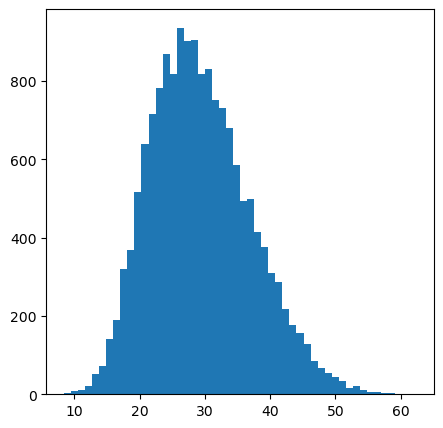

In [36]:
# first, distance between SNP sites that represent window centers.
# calculating distance between neigbouring SNP window centers within chromosomes

# we have the same SNPs across pairs
# what changes is the Fst value, not the position. We can use only one pair comparison
# creats the dataframe with position and distance to nearest SNP down the stream (plus sense in the ref. seq)
wsnp_info = windsnps[windsnps['pair'] == 'pools12'][['position','chr']]
wsnp_info['dist'] = wsnp_info.groupby('chr')['position'].diff()

# 16081 distance points
# print(wsnp_info[~wsnp_info['dist'].isna()].describe)

# plot the frquency of distances between SNPs within every contig
fig, ax = plt.subplots(figsize = (5,5), facecolor = 'w')

ax.hist(wsnp_info['dist'], bins=50)

plt.show()

# no distance between SNPs within the same contig is more than 100 nucleotides
# meaning that,
# even though poolfstats global Fst by windows reports as position the centre position from all SNPs included in the window (10)
# using that position to retrieve the differentiated region (+- 500 nucleotides around) is not missing out
# the actual SNP position.

In [37]:
# now we need to annotate all data SNPs with the mean coverate and read countdata
data

# compare the position based on our window calculation and that of poolfstats
data[['chr','position']]
data[data['chr'] == 'NODE_103251_length_1585_cov_29.275817'][['chr','position','multilocusfst','pair']]

,chr,position,multilocusfst,pair
835,NODE_103251_length_1585_cov_29.275817,1472,-0.043879,pools12
836,NODE_103251_length_1585_cov_29.275817,1501,-0.046336,pools12
837,NODE_103251_length_1585_cov_29.275817,1533,-0.031840,pools12
29292,NODE_103251_length_1585_cov_29.275817,1472,0.585356,pools13
29293,NODE_103251_length_1585_cov_29.275817,1501,0.498358,pools13
29294,NODE_103251_length_1585_cov_29.275817,1533,0.291440,pools13
57749,NODE_103251_length_1585_cov_29.275817,1472,0.731404,pools14
57750,NODE_103251_length_1585_cov_29.275817,1501,0.653466,pools14
57751,NODE_103251_length_1585_cov_29.275817,1533,0.361496,pools14
86206,NODE_103251_length_1585_cov_29.275817,1472,0.624540,pools23


In [38]:
p0999 # 0.999 quantile threshold of Fst values
windsnps.columns
# Fst values calculated using pandas' rolling are different from the multilocusfst calculated by poolfstats
# since poolfstats has corrections and a proper calculation implemented
# we will work with that and not the fst calculated here


# also note that the position calculated by us is preported by poolfstat as rounded down
windsnps[windsnps['chr'] == 'NODE_103251_length_1585_cov_29.275817'][['chr','position','pair']]

,chr,position,pair
4105,NODE_103251_length_1585_cov_29.275817,1472.4,pools12
4106,NODE_103251_length_1585_cov_29.275817,1501.7,pools12
4107,NODE_103251_length_1585_cov_29.275817,1533.5,pools12
79284,NODE_103251_length_1585_cov_29.275817,1472.4,pools13
79285,NODE_103251_length_1585_cov_29.275817,1501.7,pools13
79286,NODE_103251_length_1585_cov_29.275817,1533.5,pools13
154463,NODE_103251_length_1585_cov_29.275817,1472.4,pools14
154464,NODE_103251_length_1585_cov_29.275817,1501.7,pools14
154465,NODE_103251_length_1585_cov_29.275817,1533.5,pools14
229642,NODE_103251_length_1585_cov_29.275817,1472.4,pools23


In [39]:
# floor(): rounds down to the nearest integer or decimal place
windsnps['floor_pos'] = windsnps['position'].apply(lambda x: np.floor(x)).astype('int')
windsnps[windsnps['chr'] == 'NODE_103251_length_1585_cov_29.275817'][['chr','position','floor_pos','pair']]

,chr,position,floor_pos,pair
4105,NODE_103251_length_1585_cov_29.275817,1472.4,1472,pools12
4106,NODE_103251_length_1585_cov_29.275817,1501.7,1501,pools12
4107,NODE_103251_length_1585_cov_29.275817,1533.5,1533,pools12
79284,NODE_103251_length_1585_cov_29.275817,1472.4,1472,pools13
79285,NODE_103251_length_1585_cov_29.275817,1501.7,1501,pools13
79286,NODE_103251_length_1585_cov_29.275817,1533.5,1533,pools13
154463,NODE_103251_length_1585_cov_29.275817,1472.4,1472,pools14
154464,NODE_103251_length_1585_cov_29.275817,1501.7,1501,pools14
154465,NODE_103251_length_1585_cov_29.275817,1533.5,1533,pools14
229642,NODE_103251_length_1585_cov_29.275817,1472.4,1472,pools23


In [40]:
data.columns
# data['chr_pos']
data['chr_pos'] = data['chr'] + '_' + data['position'].astype('str')
data['chr_pos']

windsnps['chr_pos'] = windsnps['chr'] + '_'  + windsnps['floor_pos'].astype('str') # any nan doesn't matter to us
# [print(x) for x in windsnps['chr_pos']]# if x in data['chr_pos']]

In [41]:
# this is actually more efficient than iterating through all possible (but not existing) pair+contig combos
data['mean_read'] = ''
data['mean_cov'] = ''

for pair in data['pair'].unique():
    for item in data['chr_pos'].values:
        if item in windsnps['chr_pos'].values:
            mean_read = windsnps[(windsnps['chr_pos'] == item) & (windsnps['pair'] == pair)]['mean_read'].values[0]
            mean_cov = windsnps[(windsnps['chr_pos'] == item) & (windsnps['pair'] == pair)]['mean_cov'].values[0]

            # get the index of the same filtered cells but in the data dataframe (the one from poolfstats)
            index = data[(data['pair'] == pair) & (data['chr_pos'] == item)].index
            # filter data and add the values to each column
            data.loc[index,'mean_read'] = mean_read
            data.loc[index,'mean_cov'] = mean_cov
            
data[['pair','chr_pos','mean_read','mean_cov']]

KeyboardInterrupt: 

In [42]:
# data.to_csv('./snp_Fst_cov_read_wind10_step5_2023.csv', sep ='\t')
data = pd.read_csv('./snp_Fst_cov_read_wind10_step5_2023.csv', sep ='\t')

In [43]:
data[['pair','chr_pos','mean_read','mean_cov']].isna().describe()

,pair,chr_pos,mean_read,mean_cov
count,170742,170742,170742,170742
unique,1,1,1,1
top,False,False,False,False
freq,170742,170742,170742,170742


In [44]:
data.columns
data[['mean_read','mean_cov']] = data[['mean_read','mean_cov']].astype('float')

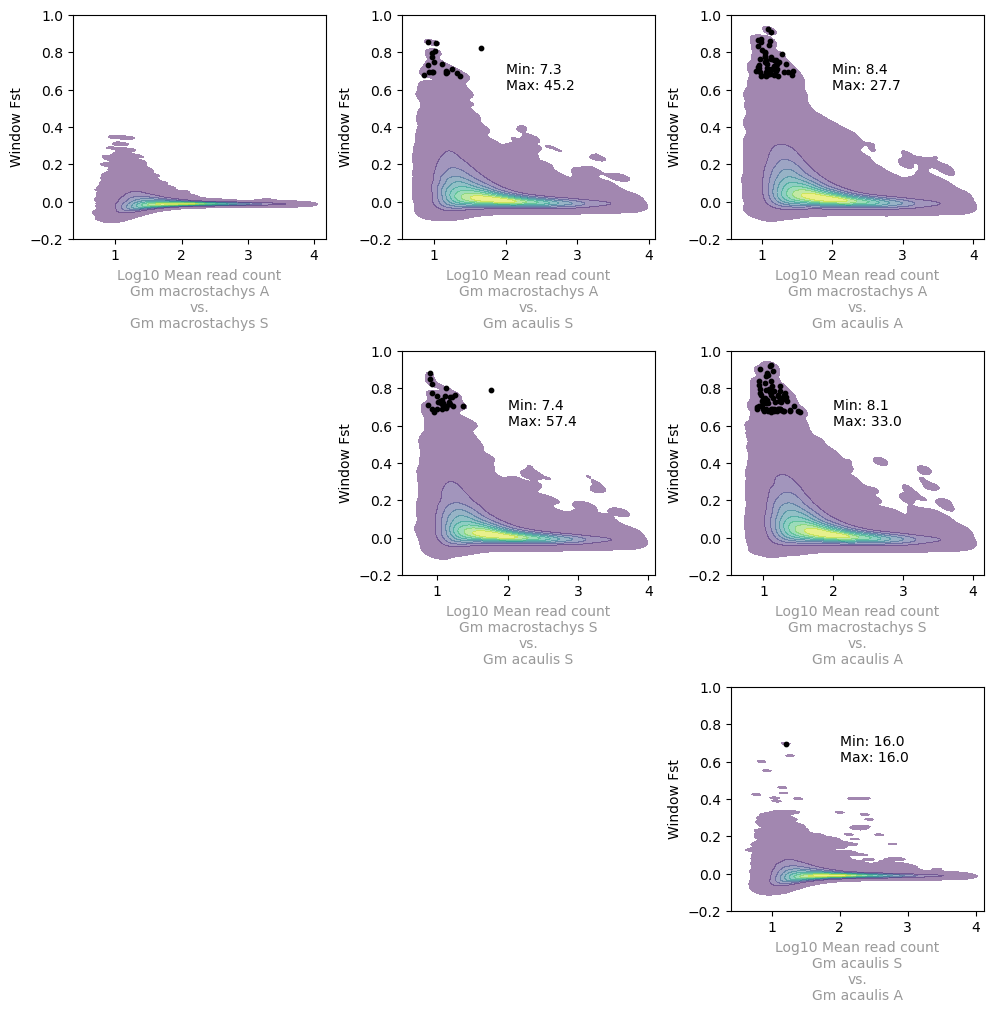

In [45]:
import seaborn as sns

# let's see the window read count and coverage distribution by comparison pair

plt.figure(figsize=(4*4,4*4),facecolor='w')
G = gridspec.GridSpec(4,4,hspace=0.5,wspace=0.3)
spinescol='#999999'

data['mean_read_log10'] = np.log10(data['mean_read'].astype('float'))

for x,y in combinations([i for i,x in enumerate(labeldict.keys())],2):
    ax = plt.subplot(G[x,y])
    ax.set_ylim(-0.2, 1)
    temp = data[data['pair'] == 'pools%s%s'%(x+1,y+1)].copy(deep = True)
    outliers = temp[temp['multilocusfst'] >= p0999]
    
    # ax.scatter(np.log10(temp1['mean_read'].astype('float')), temp1['multilocusfst'], s =10, c = '#bababa', zorder = 1)
    sns.kdeplot(x = temp['mean_read_log10'].astype('float'),
                y = temp['multilocusfst'], cmap = 'viridis', fill = True, thresh = 0.001, ax = ax, alpha = 0.5)
    ax.scatter(outliers['mean_read_log10'], outliers['multilocusfst'], s = 10, c = 'k', zorder = 2)

    if len(outliers) > 0:
        ax.text(x = 2, y = 0.6, s = 'Min: %.1f\nMax: %.1f'%(outliers['mean_read'].min(),outliers['mean_read'].max()))
        
    ax.set_xlabel('%s\nvs.\n%s'%(labeldict[list(labeldict.keys())[x]],labeldict[list(labeldict.keys())[y]]),
                  fontsize = 10, color = spinescol)
    plt.ylabel('Window Fst')
    plt.xlabel('Log10 Mean read count\n%s\nvs.\n%s'%(labeldict[list(labeldict.keys())[x]],labeldict[list(labeldict.keys())[y]]),
                  fontsize = 10, color = spinescol)
plt.show()

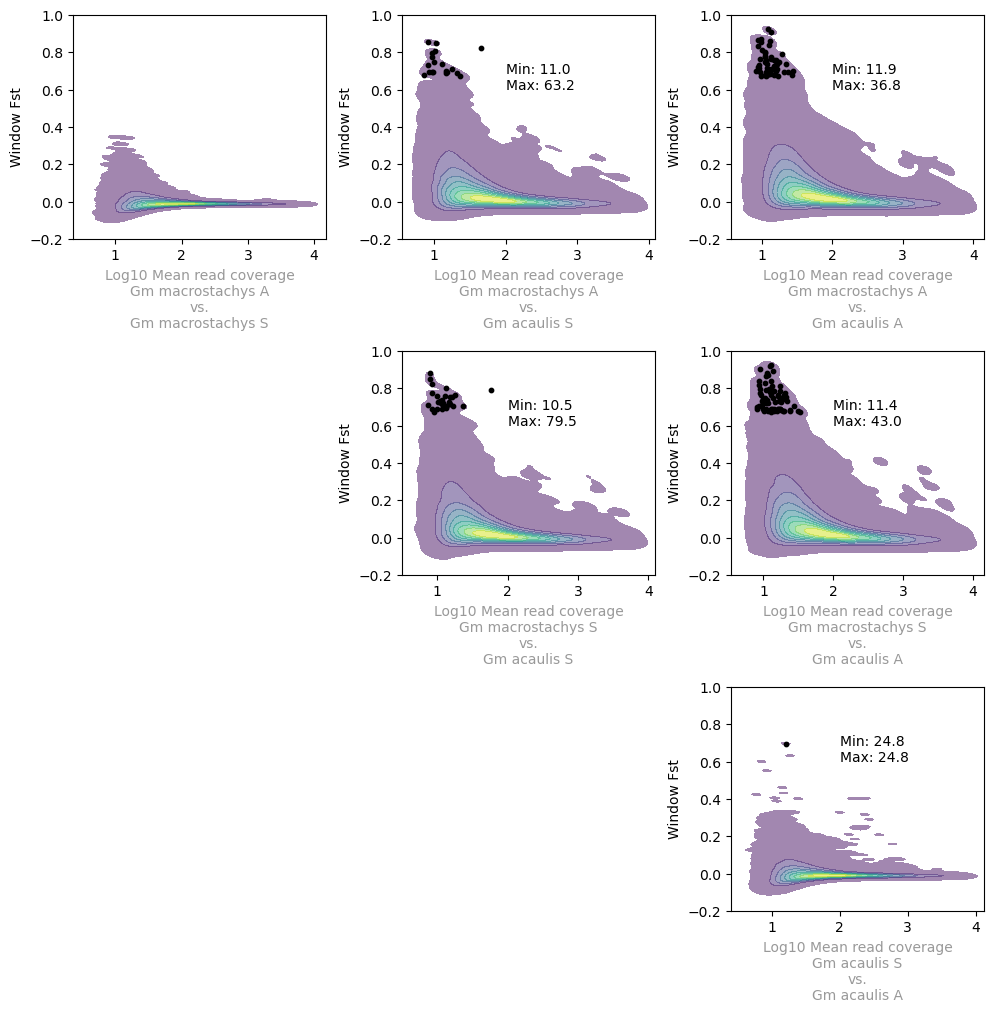

In [46]:
import seaborn as sns

# let's see the window read count and coverage distribution by comparison pair

plt.figure(figsize=(4*4,4*4),facecolor='w')
G = gridspec.GridSpec(4,4,hspace=0.5,wspace=0.3)
spinescol='#999999'

data['mean_cov_log10'] = np.log10(data['mean_read'].astype('float'))

for x,y in combinations([i for i,x in enumerate(labeldict.keys())],2):
    ax = plt.subplot(G[x,y])
    ax.set_ylim(-0.2, 1)
    temp = data[data['pair'] == 'pools%s%s'%(x+1,y+1)].copy(deep = True)
    outliers = temp[temp['multilocusfst'] >= p0999]
    
    # ax.scatter(np.log10(temp1['mean_read'].astype('float')), temp1['multilocusfst'], s =10, c = '#bababa', zorder = 1)
    sns.kdeplot(x = temp['mean_cov_log10'].astype('float'),
                y = temp['multilocusfst'], cmap = 'viridis', fill = True, thresh = 0.001, ax = ax, alpha = 0.5)
    ax.scatter(outliers['mean_cov_log10'], outliers['multilocusfst'], s = 10, c = 'k', zorder = 2)

    if len(outliers) > 0:
        ax.text(x = 2, y = 0.6, s = 'Min: %.1f\nMax: %.1f'%(outliers['mean_cov'].min(),outliers['mean_cov'].max()))
        # print(outliers['mean_cov'].describe())
        
    ax.set_xlabel('%s\nvs.\n%s'%(labeldict[list(labeldict.keys())[x]],labeldict[list(labeldict.keys())[y]]),
                  fontsize = 10, color = spinescol)
    plt.ylabel('Window Fst')
    plt.xlabel('Log10 Mean read coverage\n%s\nvs.\n%s'%(labeldict[list(labeldict.keys())[x]],labeldict[list(labeldict.keys())[y]]),
                  fontsize = 10, color = spinescol)
plt.show()

In [47]:
data['pair'].unique()
data.columns

chr_col = {}
for index, chrom in enumerate(data['chr'].unique()):
    if (index % 2) == 0:
        chr_col[chrom] = '#a3a3a3'
    else:
        chr_col[chrom] = '#6e6e6e'    

In [267]:
# chr_col

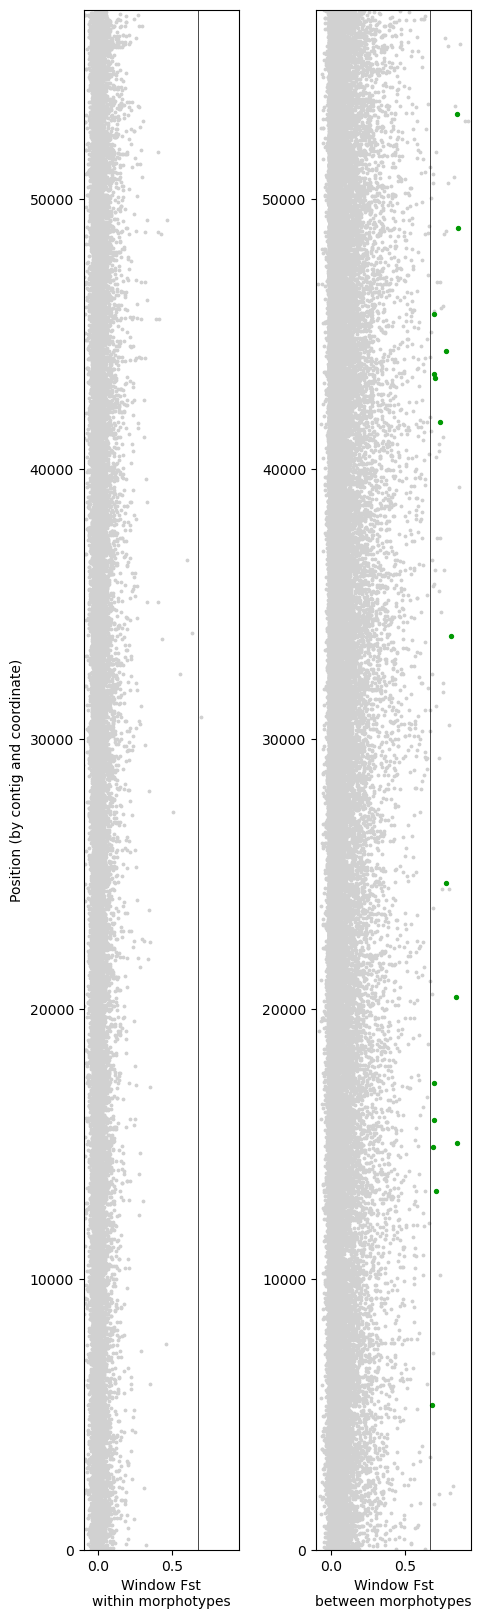

In [48]:
## plotting the SNPs from the window analysis and their Fst
# organised by contig and position

within = data[data['pair'].isin(['pools12','pools34'])].copy(deep = True)
within.sort_values(by = ['chr','position'])
within.reset_index(inplace = True)

between = data[data['pair'].isin(['pools13','pools14','pools23', 'pools24'])].copy(deep = True)
between.sort_values(by = ['chr','position'])
between.reset_index(inplace = True)

plt.figure(figsize = (5, 20), facecolor = 'w')
G = gridspec.GridSpec(1,2,wspace = 0.5)
spinescol='#999999'
background = '#d1d1d1'

ax = plt.subplot(G[0,0])
# ax.set_xlim(0,57000)
# ax.scatter(within.index,within['multilocusfst'], s = 3, c = '#bababa')
# ax.hlines(y = p0999, xmin = ax.get_xlim()[0], xmax = ax.get_xlim()[1], color = 'k', lw = 0.5)
# plt.ylabel('Window Fst')
ax.set_ylim(0,57000); ax.set_xlim(-0.10,0.95)
ax.scatter(within['multilocusfst'], within.index, s = 3, c = background)
ax.vlines(x = p0999, ymin = ax.get_ylim()[0], ymax = ax.get_ylim()[1], color = 'k', lw = 0.5)
plt.ylabel('Position (by contig and coordinate)')
plt.xlabel('Window Fst\nwithin morphotypes')


ax = plt.subplot(G[0,1])
# ax.set_xlim(0,57000)
# ax.scatter(between.index,between['multilocusfst'], s = 3, c = '#bababa')
# ax.hlines(y = p0999, xmin = ax.get_xlim()[0], xmax = ax.get_xlim()[1], color = 'k', lw = 0.5)
ax.set_ylim(0,57000); ax.set_xlim(-0.10,0.95)
ax.scatter(between['multilocusfst'], between.index, s = 3, c = background)
ax.vlines(x = p0999, ymin = ax.get_ylim()[0], ymax = ax.get_ylim()[1], color = 'k', lw = 0.5)

outlierin4 = alloutliers.groupby(by = 'chr')['pair'].nunique().reset_index()
outlierin4cont = list(outlierin4[outlierin4['pair'] == 4]['chr'].values)
outsin4 = between[(between['chr'].isin(outlierin4cont)) & (between['multilocusfst'] >= p0999)]
ax.scatter(outsin4['multilocusfst'], outsin4.index, s = 8, c = '#009903')

plt.xlabel('Window Fst\nbetween morphotypes')
plt.show()

In [49]:
outlierin4 = alloutliers.groupby(by = 'chr')['pair'].nunique().reset_index()
outlierin4cont = list(outlierin4[outlierin4['pair'] == 4]['chr'].values)
outlierin4cont

['NODE_120032_length_1286_cov_13.319253',
 'NODE_27539_length_5914_cov_26.672128',
 'NODE_39350_length_4397_cov_23.751727',
 'NODE_40349_length_4296_cov_20.967461',
 'NODE_45647_length_3846_cov_21.909259',
 'NODE_53780_length_3292_cov_33.146741',
 'NODE_69607_length_2545_cov_18.633333',
 'NODE_87958_length_1956_cov_14.082062']

In [50]:
p0999
data.columns
data[(data['multilocusfst'] >= p0999) & (data['chr'].isin(outlierin4cont))][['mean_read','mean_cov']].describe()

,mean_read,mean_cov
count,32.000000,32.000000
mean,11.703125,16.750000
std,3.928411,4.858896
min,7.300000,10.500000
25%,8.737500,12.825000
50%,10.275000,16.075000
75%,14.425000,20.125000
max,22.150000,27.700000


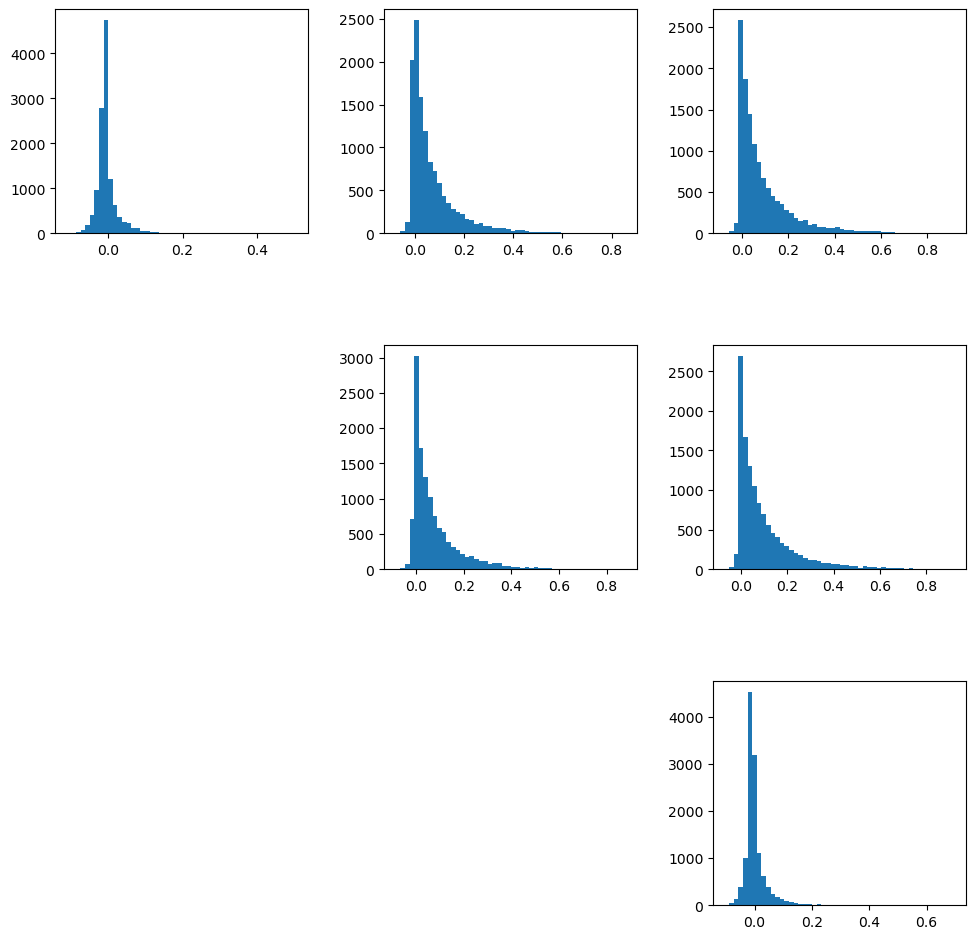

In [61]:
# checking the average Fsp per contig to identify outlier contigs (proxy for Fst windowns since the contigs are so short anyways)
# without adding non-variable sites that would have an Fst of 0

plt.figure(figsize=(4*4,4*4),facecolor='w')
G = gridspec.GridSpec(4,4,hspace=0.5,wspace=0.3)
spinescol='#999999'

for x,y in combinations([i for i,x in enumerate(labeldict.keys())],2):
    ax = plt.subplot(G[x,y])
    # ax.set_ylim(-0.2, 1)
    temp = data[data['pair'] == 'pools%s%s'%(x+1,y+1)].copy(deep = True)
    tempg = temp.groupby(by = 'chr')['multilocusfst'].mean().reset_index()
    
    ax.hist(tempg['multilocusfst'], bins = 50)
    # outliers = temp[temp['multilocusfst'] >= p0999]
    
    # # ax.scatter(np.log10(temp1['mean_read'].astype('float')), temp1['multilocusfst'], s =10, c = '#bababa', zorder = 1)
    # sns.kdeplot(x = temp['mean_cov_log10'].astype('float'),
    #             y = temp['multilocusfst'], cmap = 'viridis', fill = True, thresh = 0.001, ax = ax, alpha = 0.5)
    # ax.scatter(outliers['mean_cov_log10'], outliers['multilocusfst'], s = 10, c = 'k', zorder = 2)

    # if len(outliers) > 0:
    #     ax.text(x = 2, y = 0.6, s = 'Min: %.1f\nMax: %.1f'%(outliers['mean_cov'].min(),outliers['mean_cov'].max()))
    #     # print(outliers['mean_cov'].describe())
        
    # ax.set_xlabel('%s\nvs.\n%s'%(labeldict[list(labeldict.keys())[x]],labeldict[list(labeldict.keys())[y]]),
    #               fontsize = 10, color = spinescol)
    # plt.ylabel('Window Fst')
    # plt.xlabel('Log10 Mean read coverage\n%s\nvs.\n%s'%(labeldict[list(labeldict.keys())[x]],labeldict[list(labeldict.keys())[y]]),
    #               fontsize = 10, color = spinescol)
plt.show()

In [62]:
# adding positions that are not variable and have Fst = 0 
bamheader = pd.read_csv('./P13454_101_selected.file', sep ='\s', names = ['contig','length'], engine='python')
bamheader.sort_values(by = 'contig', inplace = True)
bamheader.reset_index(inplace = True)
bamheader

,index,contig,length
0,94935,NC_017602.1_RagTag_RagTag,49414
1,95271,NC_025993.1_RagTag_RagTag,31286264
2,95270,NC_025994.1_RagTag_RagTag,30374397
3,95269,NC_025995.1_RagTag_RagTag,25755588
4,95268,NC_025996.1_RagTag_RagTag,23738005
...,...,...,...
95267,33034,NW_011590365.1_RagTag_RagTag,1519
95268,89244,NW_011590636.1_RagTag_RagTag,6012
95269,47375,NW_011590757.1_RagTag_RagTag,1909
95270,93354,NW_011590802.1_RagTag_RagTag,9893


In [74]:
cont_len = dict(zip(bamheader['contig'].astype(str), bamheader['length']))
# cont_len

contiggvcf_fst = pd.DataFrame(columns = ['chr','multilocusfst','fst_gvcf_mean','pair'])
    
for pair in data['pair'].unique():
    temp = data[data['pair'] == pair].copy(deep = True)
    tempg = temp.groupby(by = 'chr')['multilocusfst'].sum().reset_index()
    
    tempg['fst_gvcf_mean'] = ''
    for index,row in enumerate(tempg.itertuples()):
        tempg.loc[index,'fst_gvcf_mean'] = row.multilocusfst / cont_len[row.chr]
        tempg.loc[index,'pair'] = pair
        
    contiggvcf_fst = pd.concat([contiggvcf_fst,tempg], sort = False)
contiggvcf_fst

,chr,multilocusfst,fst_gvcf_mean,pair
0,NC_025997.1_RagTag_RagTag,-0.014640,-0.0,pools12
1,NC_026004.1_RagTag_RagTag,0.016542,0.0,pools12
2,NC_026007.1_RagTag_RagTag,-0.031344,-0.0,pools12
3,NODE_100003_length_1654_cov_23.324578,-0.041583,-0.000025,pools12
4,NODE_100025_length_1654_cov_12.582239,0.037946,0.000023,pools12
...,...,...,...,...
12371,NW_011586595.1_RagTag_RagTag,-0.038338,-0.000015,pools34
12372,NW_011586681.1_RagTag_RagTag,0.019453,0.000011,pools34
12373,NW_011586930.1_RagTag_RagTag,-0.006202,-0.000002,pools34
12374,NW_011587330.1_RagTag_RagTag,0.006760,0.000001,pools34


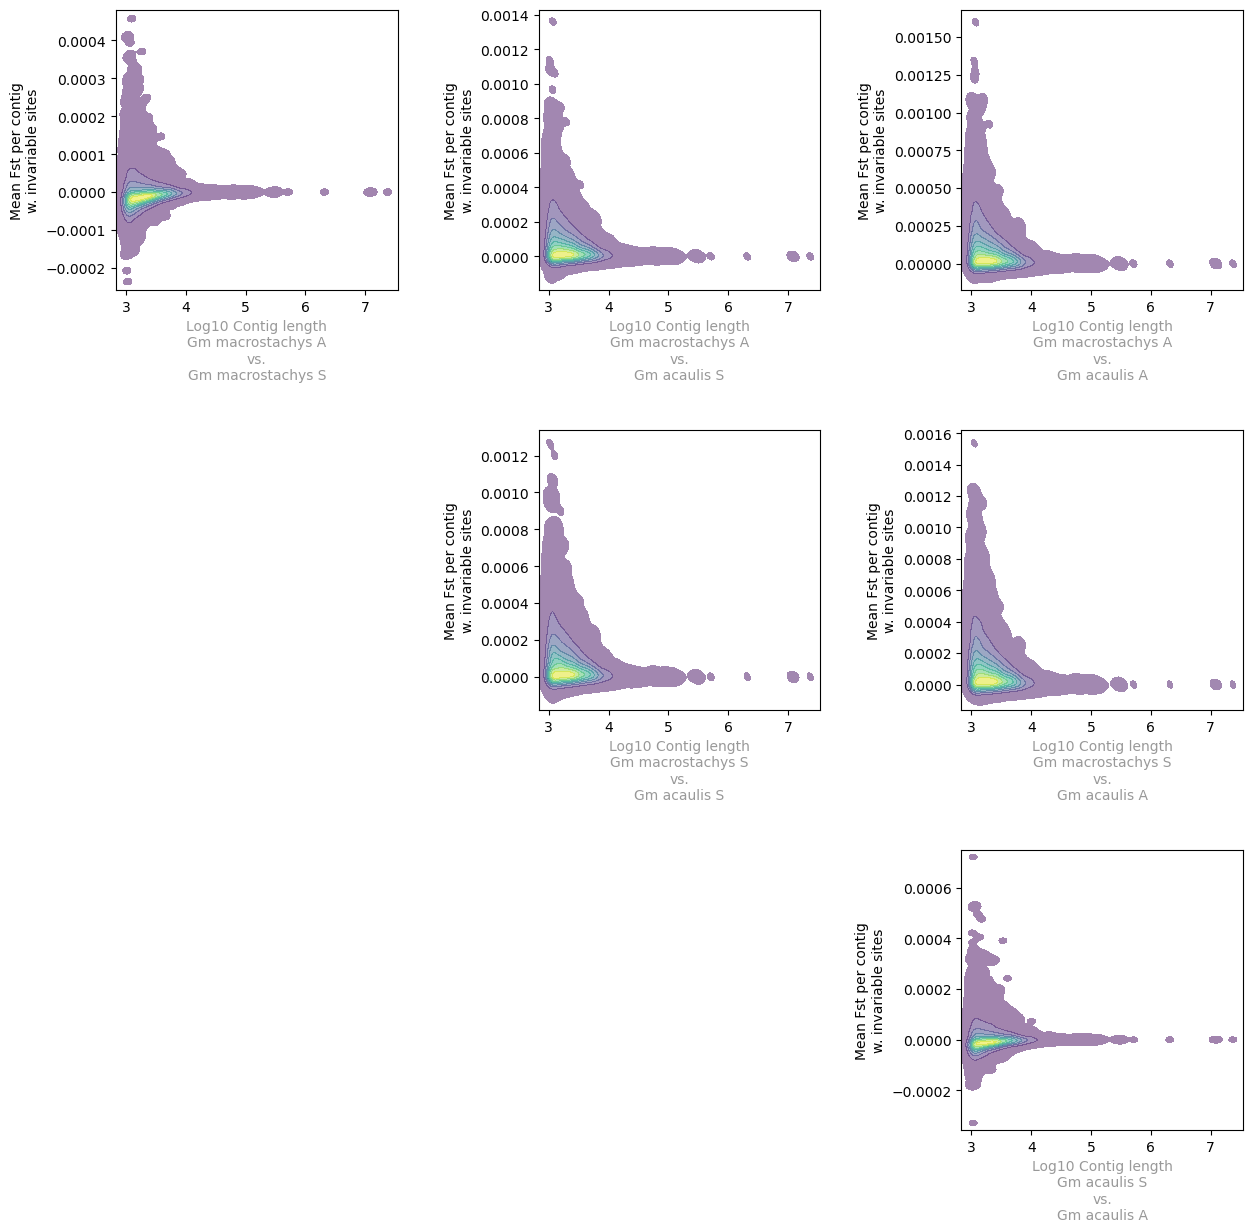

In [85]:
# subset data or the table will get huge and with loads of nans in columns we dont need for this plot
# we can do this for one pair only, the unvariable sites per contig are the same regardless and we can add them at the end
# as a sum of 0*number of those sites sum Fst on the rest of the sites
# divided by the total lenght, not just the variable sites

plt.figure(figsize=(5*4,5*4),facecolor='w')
G = gridspec.GridSpec(4,4,hspace=0.5,wspace=0.5)
spinescol='#999999'

for x,y in combinations([i for i,x in enumerate(labeldict.keys())],2):
    ax = plt.subplot(G[x,y])
    # ax.set_xlim(-0.2, 0.8)
    temp = contiggvcf_fst[contiggvcf_fst['pair'] == 'pools%s%s'%(x+1,y+1)].copy(deep = True)
    
    # ax.hist(temp['fst_gvcf_mean'], bins = 50)
    sns.kdeplot(x = np.log10(temp['chr'].map(cont_len).astype('float')),
            y = temp['fst_gvcf_mean'], cmap = 'viridis', fill = True, thresh = 0.001, ax = ax, alpha = 0.5)
    # ax.vlines(x = p0999, ymin = ax.get_ylim()[0], ymax = ax.get_ylim()[1])

    ax.set_xlabel('%s\nvs.\n%s'%(labeldict[list(labeldict.keys())[x]],labeldict[list(labeldict.keys())[y]]),
                  fontsize = 10, color = spinescol)
    plt.ylabel('Mean Fst per contig\nw. invariable sites')
    plt.xlabel('Log10 Contig length\n%s\nvs.\n%s'%(labeldict[list(labeldict.keys())[x]],labeldict[list(labeldict.keys())[y]]),
                  fontsize = 10, color = spinescol)
plt.show()
    

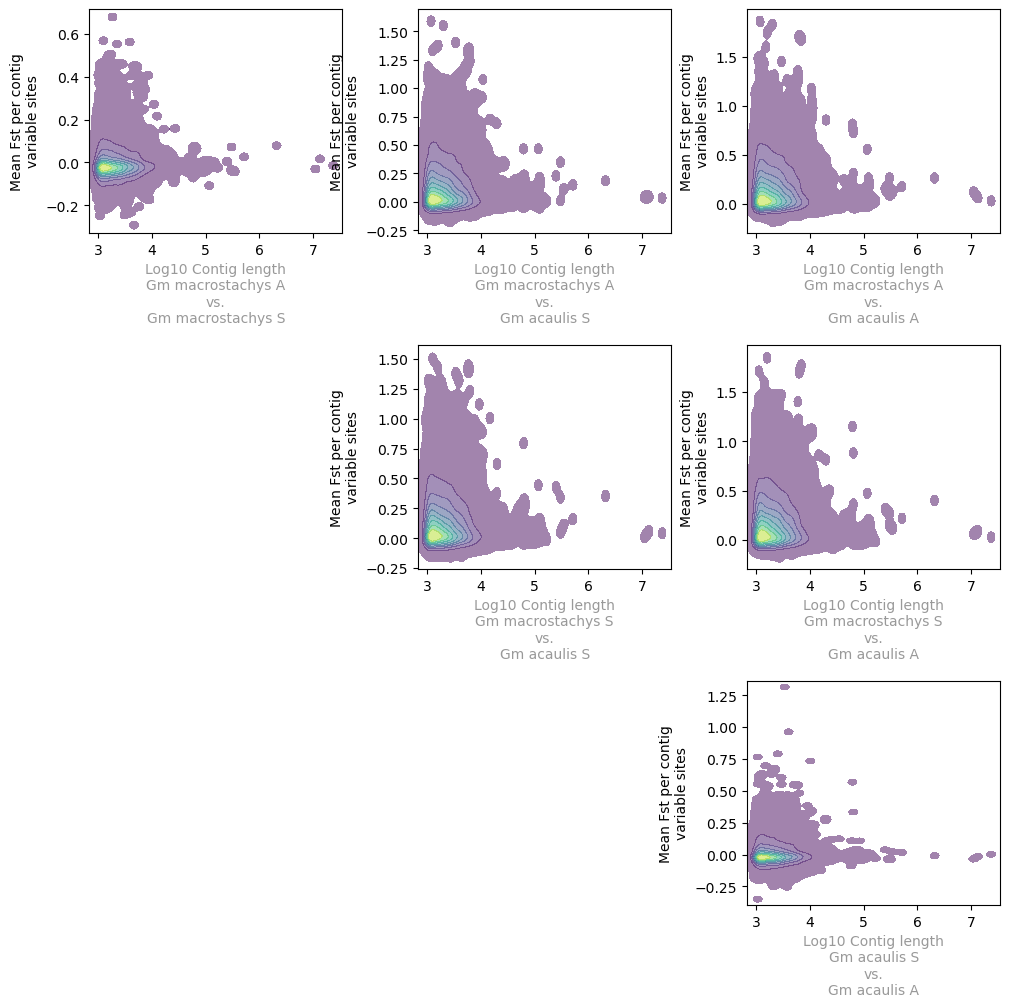

In [84]:
# subset data or the table will get huge and with loads of nans in columns we dont need for this plot
# we can do this for one pair only, the unvariable sites per contig are the same regardless and we can add them at the end
# as a sum of 0*number of those sites sum Fst on the rest of the sites
# divided by the total lenght, not just the variable sites

plt.figure(figsize=(4*4,4*4),facecolor='w')
G = gridspec.GridSpec(4,4,hspace=0.5,wspace=0.3)
spinescol='#999999'

for x,y in combinations([i for i,x in enumerate(labeldict.keys())],2):
    ax = plt.subplot(G[x,y])
    # ax.set_xlim(-0.2, 0.8)
    temp = contiggvcf_fst[contiggvcf_fst['pair'] == 'pools%s%s'%(x+1,y+1)].copy(deep = True)
    
    # ax.hist(temp['fst_gvcf_mean'], bins = 50)
    sns.kdeplot(x = np.log10(temp['chr'].map(cont_len).astype('float')),
            y = temp['multilocusfst'], cmap = 'viridis', fill = True, thresh = 0.001, ax = ax, alpha = 0.5)
    # ax.vlines(x = p0999, ymin = ax.get_ylim()[0], ymax = ax.get_ylim()[1])

    ax.set_xlabel('%s\nvs.\n%s'%(labeldict[list(labeldict.keys())[x]],labeldict[list(labeldict.keys())[y]]),
                  fontsize = 10, color = spinescol)
    plt.ylabel('Mean Fst per contig\nvariable sites')
    plt.xlabel('Log10 Contig length\n%s\nvs.\n%s'%(labeldict[list(labeldict.keys())[x]],labeldict[list(labeldict.keys())[y]]),
                  fontsize = 10, color = spinescol)
plt.show()
    

In [ ]:
# subset data or the table will get huge and with loads of nans in columns we dont need for this plot
# we can do this for one pair only, the unvariable sites per contig are the same regardless and we can add them at the end
# as a sum of 0*number of those sites sum Fst on the rest of the sites
# divided by the total lenght, not just the variable sites

plt.figure(figsize=(4*4,4*4),facecolor='w')
G = gridspec.GridSpec(4,4,hspace=0.5,wspace=0.3)
spinescol='#999999'

for x,y in combinations([i for i,x in enumerate(labeldict.keys())],2):
    ax = plt.subplot(G[x,y])
    # ax.set_xlim(-0.2, 0.8)
    temp = contiggvcf_fst[contiggvcf_fst['pair'] == 'pools%s%s'%(x+1,y+1)].copy(deep = True)
    
    ax.hist(temp['fst_gvcf_mean'], bins = 50)
    # ax.vlines(x = p0999, ymin = ax.get_ylim()[0], ymax = ax.get_ylim()[1])

    ax.set_xlabel('%s\nvs.\n%s'%(labeldict[list(labeldict.keys())[x]],labeldict[list(labeldict.keys())[y]]),
                  fontsize = 10, color = spinescol)
    plt.ylabel('Number of contigs')
    plt.xlabel('Mean Fst per contig including invariable sites\n%s\nvs.\n%s'%(labeldict[list(labeldict.keys())[x]],labeldict[list(labeldict.keys())[y]]),
                  fontsize = 10, color = spinescol)
plt.show()
    

In [54]:
# 1,327,057 # total sites
# 170,742 # SNPs used by poolfstats
data['outlier'].describe()

count     170742
unique         2
top         base
freq      170064
Name: outlier, dtype: object